## SUM149 and SUM159 cell line analysis

**Author:Dr.Xi Li**

**Created: 01/21/21**

**Language: Python**

This document serves to provide analysis to SUM149 and SUM159 data it takes as imput is a loom file extracted from velocyto and provides H5d5 for storage, as well as several figures and tables as output.


NOTE: cyto trace file must be present in the directory that this script is located in

In [1]:
from matplotlib import rcParams
import matplotlib.pyplot as plt
import scvelo as scv
import loompy
import pandas as pd
import numpy as np
import os
import scanpy as sc
import scipy.stats as stats
from io import StringIO
from sklearn import linear_model
import seaborn as sns
 
%matplotlib inline

In [2]:
scv.settings.verbosity = 3  # show errors(0), warnings(1), info(2), hints(3)
scv.settings.presenter_view = True  # set max width size for presenter view
scv.settings.set_figure_params('scvelo')

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
# for beautified visualization

## input sample path

First lets find the directory that we are working in

**Note:  SigsDir must be changed depending on the user to allow for proper use of this script**

In [3]:
os.getcwd()

'/mnt/c9b6130c-37e5-4f62-becc-dd4240b42021/T127_T22_ola_2'

In [4]:
#set directory to where signature gene lists locates
SigsDir="/mnt/533ee9c3-18c0-4c72-a09e-d9ce5a10ef9e/sig"

## Unique Gene Names

First we want to select the genes that we wish to look at and format them into a data frame that we can use later on

In [91]:
#set the directory for outputs

project_ID="pool_reconcat_new_new_new"
scv.settings.figdir=f'{project_ID}_figures'

In [92]:
#load the loom from velocyto output
adata=scv.read (f"{project_ID}_figures/{project_ID}_anno.h5ad")

In [99]:
#adata.raw=adata
raw=pd.DataFrame(data=adata.raw.X.toarray(), index=adata.obs_names, columns=adata.raw.var_names)

In [100]:
adata_raw= sc.AnnData(raw)
for i in np.unique(adata.obs.columns):
    adata_raw.obs[i]=adata.obs[i]

In [101]:
scv.pp.filter_and_normalize(adata_raw, min_cells=0.001*(adata.n_obs), flavor="seurat")
sc.pp.log1p(adata_raw)

Normalized count data: X.
Logarithmized X.


In [102]:
adata.raw=adata_raw

In [ ]:
adata.obs["anno_clusters"]=adata_.obs["anno_clusters"]

In [ ]:
adata_=scv.read (f"pool_malign_short_figures/pool_malign_short_anno.h5ad")

In [ ]:
adata=sc.read("pool_reconcat.h5ad")

In [ ]:
for i in np.unique(adata.obs.treatment):
    print(i, adata[adata.obs.treatment==i].n_obs)

In [ ]:
adata=adata[adata_[adata_.obs.treatment.str.startswith("T127")].obs_names]
adata=adata[:,adata_.var_names]

In [ ]:
adata.obs["RSR_clusters"]=adata_[adata_.obs.treatment.str.startswith("T127")].obs.RSR_clusters
adata.obs["RSR_sample_brf"]=adata_[adata_.obs.treatment.str.startswith("T127")].obs.RSR_sample_brf
adata.obs["RSR_group"]=adata_[adata_.obs.treatment.str.startswith("T127")].obs.RSR_group

In [ ]:
adata=adata[(adata.obs.treatment.str.startswith("T127s")) | (adata.obs.treatment.str.startswith("T22s")) |
           (adata.obs.treatment.str.startswith("T127co")) | (adata.obs.treatment.str.startswith("T22co"))]
adata=adata[adata.obs.anno_clusters.str.startswith("Malign")]
adata.raw=adata

In [ ]:
adata_=adata_[adata.obs_names]

In [ ]:
#adata=adata[ (adata.obs.treatment.str.startswith("T22_")) ]
#adata=adata[adata.obs.cell_type.str.startswith("T")]
adata.obs["treatment"]=adata_.obs["treatment"]

In [ ]:
Sample_idx=pd.Series("Unknown", index=adata.obs_names)
m=0
for i in np.unique(adata.obs.treatment):   
    Sample_idx[adata.obs.treatment==i]=m
    m=m+1
adata.obs["Sample_idx"]=Sample_idx.values
adata.obs["Sample_idx"]=adata.obs["Sample_idx"].astype(float)

In [ ]:
#store a h5ad file for further faster loadinig
adata.var_names_make_unique("_")

#we need to make a directory to store the files in
try:
    directoryName=project_ID+"_figures"
    os.mkdir(directoryName)
except:
    pass

#we need to make a directory to store the files in
#we need to make a directory to store the files in
try:
    directoryName=project_ID+"_DEG"
    os.mkdir(directoryName)
except:
    pass


In [ ]:
adata_mye=sc.read_csv(f"/mnt/533ee9c3-18c0-4c72-a09e-d9ce5a10ef9e/T_anno_ref/BrCa_myeloid_scPred_training_mtx.csv", delimiter=',', first_column_names=None, dtype='float32')

In [ ]:
adata_mye.var_names=[x.capitalize() for x in adata_mye.var_names]

In [ ]:
adata_mye=adata_mye[:,[x for x in adata_mye.var_names if (x in adata_mye.var_names)&(x in adata.var_names)]]
adata_mye.var_names_make_unique()

In [ ]:
adata=adata[:,[x for x in adata.var_names if (x in adata_mye.var_names)&(x in adata.var_names)]]
adata.var_names_make_unique()

In [ ]:
adata_mye.obs["anno_clusters"]=pd.read_csv(f"/mnt/533ee9c3-18c0-4c72-a09e-d9ce5a10ef9e/T_anno_ref/BrCa_myeloid_scPred_training_meta.csv", sep=",", index_col=0).values

In [ ]:
adata=adata_mye

In [ ]:
adata_mye=adata

In [ ]:
#re-load the adata or not
adata = sc.read(f'{project_ID}_figures/{project_ID}_anno.h5ad', gex_only=True)
adata.raw=adata

## Preprocess the Data

now we will take the files from the previous section where we determined spliced/unspliced RNA counts and use them to create RNA velocity trajectory as well as investigate biological alternation in each cell

In [ ]:
#calculate the percentage of mitochondrial genes and ribosomal genes
adata.var['mt'] = adata.var_names.str.startswith('mt-')
adata.var['rp'] = adata.var_names.str.startswith('Rp')
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
sc.pp.calculate_qc_metrics(adata, qc_vars=['rp'], percent_top=None, log1p=False, inplace=True)
#sc.pl.violin(adata, ['n_vars'], groupby='Sample_ID', stripplot=False) 

In [ ]:
#plot scatter plots of dataset QC
sc.pl.scatter(adata, x='n_genes_by_counts', y='pct_counts_mt')#, color="GEX_ID",)
sc.pl.scatter(adata, x='n_genes_by_counts', y='pct_counts_rp', color="GEX_ID",)
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts',color="GEX_ID")

In [ ]:
#filter out outliers
#adata = adata[adata.obs.n_genes_by_counts < 8000, :] #we want the cell to contain less than 5000 total gene detected in order to avoid doublets
#adata = adata[adata.obs.total_counts < 80000, :]
adata = adata[adata.obs.n_genes_by_counts > 2000, :] #we want the cell to contain more than 200 total gene detected in order to avoid bad cells
adata = adata[adata.obs.total_counts > 6000, :]# we want the cell to contain more than 400 (200*2) total counts (UMI) detected in order to avoid bad cells
adata = adata[adata.obs.pct_counts_mt < 10, :]# we want the cell to contain less than 55 percent mitochondrial genes in order to avoid bad cells

adata

## Load CNV results

In [ ]:
cellAnno=pd.read_csv("/mnt/533ee9c3-18c0-4c72-a09e-d9ce5a10ef9e/jobs/T127_ola_4d_8d/results/combine_s/Malign_score.csv",header=0, sep=",",index_col=1)

In [ ]:
adata.obs["Malign_score"]=cellAnno["Malign_score"].values

In [ ]:
Malign = pd.Series("nonMalignancy", index=cellAnno.index)  # default phase is S
Malign[adata.obs["Malign_score"].values > 1.04] = "Malignancy"  # G2M, if G2M is higher than S
adata.obs["Malign_type"]=Malign.values

***

when cell membrane is broken, cytoplasmic RNA will be easy to leek out, but mitochondia are still too big to pass the broken membrane, so that high percentage usually suggestes bad cells. But on the contrary, there is paper saying stemness like cell containing high percentage mitochondrial genes to survie stress, so we have to go back to this parameters according to what we will have found later.

**Doublets section**

This section should only be used if the dataframe contains doublets.


In [ ]:
#calculate doublets but we don't do this for SUM149 datasets
import scrublet as scr
scrub = scr.Scrublet(adata.raw.X, expected_doublet_rate=0.06,n_neighbors=0.5*np.sqrt(adata.n_obs))

In [ ]:
adata.obs['doublet_scores'], adata.obs['predicted_doublets'] = scrub.scrub_doublets(min_counts=5, 
                                                          min_cells=0.1%(len(adata.to_df())), 
                                                          min_gene_variability_pctl=95, 
                                                          n_prin_comps=30)
scrub.plot_histogram()

In [ ]:
singlet_list = [cells for cells in adata.obs_names if not adata.obs['predicted_doublets'][cells]]
adata = adata[singlet_list,:]

**Continued data processing**

In [ ]:
int(0.5*np.sqrt(adata.n_obs))

In [ ]:
scv.pp.filter_and_normalize(adata, min_cells=0.001*(len(adata.to_df())),#n_top_genes=4000,
                             flavor="cell_ranger")
scv.tl.score_genes_cell_cycle(adata, s_genes= ['Mcm5', 'Pcna', 'Tyms', 'Fen1', 'Mcm2', 'Mcm4', 'Rrm1', 'Ung', 'Gins2',
     'Mcm6', 'Cdca7', 'Dtl', 'Prim1', 'Uhrf1', 'Mlf1ip', 'Hells', 'Rfc2',
     'Rpa2', 'Nasp', 'Rad51ap1', 'Gmnn', 'Wdr76', 'Slbp', 'Ccne2', 'Ubr7',
     'Pold3', 'Msh2', 'Atad2', 'Rad51', 'Rrm2', 'Cdc45', 'Cdc6', 'Exo1', 'Tipin',
     'Dscc1', 'Blm', 'Casp8ap2', 'Usp1', 'Clspn', 'Pola1', 'Chaf1b', 'Brip1', 'E2f8'], g2m_genes = ['Hmgb2', 'Cdk1', 'Nusap1', 'Ube2c', 'Birc5', 'Tpx2', 'Top2a', 'Ndc80',
     'Cks2', 'Nuf2', 'Cks1b', 'Mki67', 'Tmpo', 'Cenpf', 'Tacc3', 'Fam64a',
     'Smc4', 'Ccnb2', 'Ckap2l', 'Ckap2', 'Aurkb', 'Bub1', 'Kif11', 'Anp32e',
     'Tubb4b', 'Gtse1', 'Kif20b', 'Hjurp', 'Cdca3', 'Hn1', 'Cdc20', 'Ttk',
     'Cdc25c', 'Kif2c', 'Rangap1', 'Ncapd2', 'Dlgap5', 'Cdca2', 'Cdca8',
     'Ect2', 'Kif23', 'Hmmr', 'Aurka', 'Psrc1', 'Anln', 'Lbr', 'Ckap5',
     'Cenpe', 'Ctcf', 'Nek2', 'G2e3', 'Gas2l3', 'Cbx5', 'Cenpa']) # calculate cell cycle score with scv internal function and its gene list of s phase and g2m phase, then we will have two observations---"S_score" and "G2M_score" added in adata 
sc.pp.regress_out(adata, keys=["S_score","G2M_score","total_counts","n_genes_by_counts"] , n_jobs=None, copy=False) # we remove cell cycle effects
scv.pp.moments(adata,n_pcs=10, n_neighbors=50, mode="distances") # we calculate a moment matrix for further RNA velocity analysis

In [ ]:
order=['CD4_Tcm-TCF7',
       'CD4_Treg-FOXP3', 'CD8_Tn-CCR7', 
 'Tgd', 'Tprf-MKI67',
 'NK.cells','B.cells',
 'pDC',
 'CD14-IL1B',
 'CD14-PF4',
 'CD16-CDKN1C',
 'Macro-M1',
 'Macro-M2',
 'Macro-MGP',
 'Macro-MKI67',
 'Malign_0', 'Malign_1',
       'Malign_2', 'Malign_3', 
 'i_CAF',
 'my_CAF',
'Endo.cells',]

In [ ]:
adata.obs['anno_clusters'].cat.reorder_categories(order, inplace=True)

In [ ]:
#calculate umap
scv.tl.umap(adata, n_components=2, min_dist=0.7, spread=1, maxiter=None, alpha=1.0,
            gamma=1, negative_sample_rate=5, init_pos="spectral", random_state=0, a=None,
            b=None, copy=False, method="umap", neighbors_key=None)

In [ ]:
#calculate louvain clusters based on the umap we generated previously
sc.tl.leiden(adata, resolution=2,  
                 key_added='leiden', use_weights=True)
adata.obs["clusters"]=adata.obs["leiden"]

In [ ]:
#check proportions of spliced and unspliced RNA in each cluster
scv.pl.proportions(adata)

In [ ]:
import densmap

In [ ]:
#This section can create a densmap if disired 
embedding, ro, re = densmap.densMAP(n_neighbors=200, n_epochs=500, dens_frac=0.7,
                                    min_dist=0.5,spread=1.5,
                                    dens_lambda=0.5).fit_transform(adata.to_df(layer="Ms"))
    
#input densmap information into adata
adata.obsm["X_densmap"]=embedding

In [ ]:
#plot umap grouped by treatment
plot_pattern="anno_clusters"
scv.pl.scatter(adata[adata.obs.treatment.str.startswith("T22")],# save=f"{plot_pattern}_umap.pdf",
               basis="umap",
           color=plot_pattern,legend_loc="right",
            size=30, alpha=0.8,
            palette=[ "slategrey","PeachPuff","gold",
                     "DeepSkyBlue",
                     "SpringGreen","olivedrab",
                     "orchid","lightcoral","firebrick","crimson","Pink", "tan",
                   "MidnightBlue", "DarkMagenta", "darkviolet","royalblue", 
                   "coral","RosyBrown","Goldenrod","BurlyWood","Peru",
            "Thistle","lightseagreen","CadetBlue",
            "lightsteelblue","dimgrey","black","IndianRed","PaleVioletRed","hotpink","greenyellow","forestgreen","PaleTurquoise","Aqua",] )

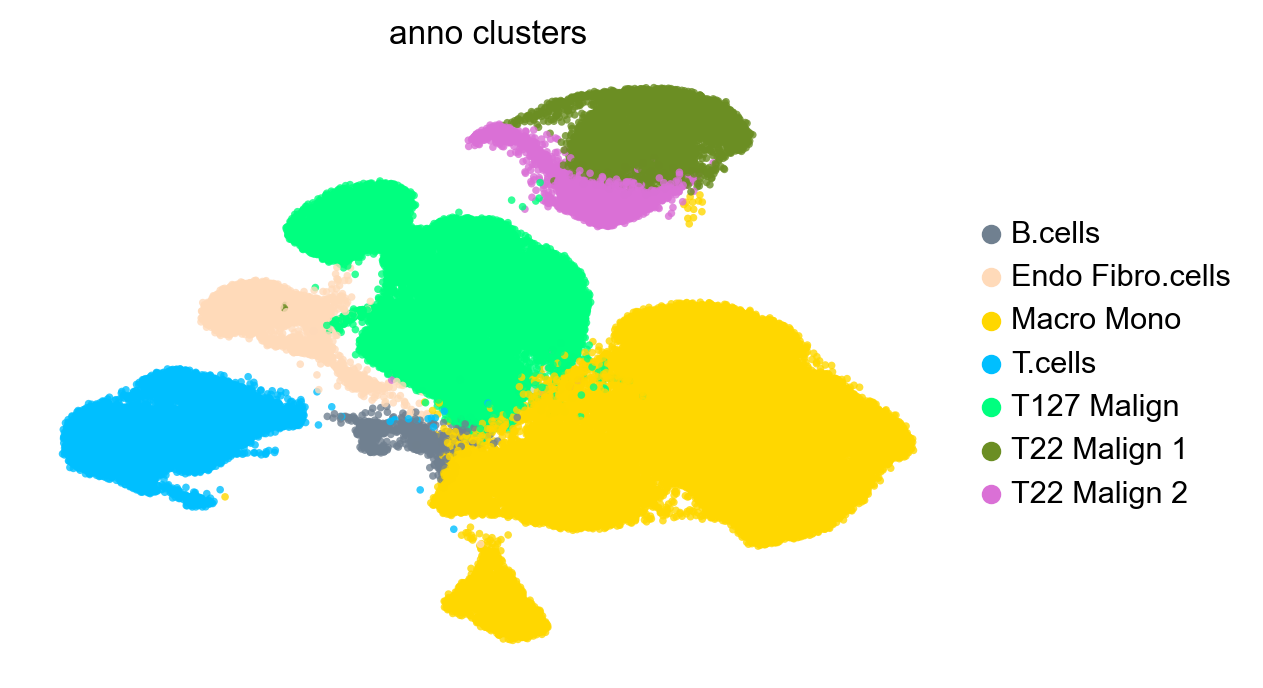

In [13]:
#plot umap grouped by treatment
plot_pattern="anno_clusters"
scv.pl.scatter(adata,#[adata.obs.treatment.str.startswith("T22")],# save=f"{plot_pattern}_umap.pdf",
               basis="umap",
           color=plot_pattern,legend_loc="right",
            size=30, alpha=0.8,
            palette=[ "slategrey","PeachPuff","gold",
                     "DeepSkyBlue",
                     "SpringGreen","olivedrab",
                     "orchid","lightcoral","firebrick","crimson","Pink", "tan",
                   "MidnightBlue", "DarkMagenta", "darkviolet","royalblue", 
                   "coral","RosyBrown","Goldenrod","BurlyWood","Peru",
            "Thistle","lightseagreen","CadetBlue",
            "lightsteelblue","dimgrey","black","IndianRed","PaleVioletRed","hotpink","greenyellow","forestgreen","PaleTurquoise","Aqua",] )

In [ ]:
#plot umap grouped by treatment
plot_pattern="anno_clusters"
scv.pl.scatter(adata[adata.obs.treatment.str.startswith("T22")], save=f"{plot_pattern}_umap.pdf",
               basis="umap",
           color=plot_pattern,legend_loc="right",
            size=30, alpha=0.8,
            palette=[ "slategrey","PeachPuff","gold",
                     "DeepSkyBlue",
                     "SpringGreen","olivedrab",
                     "orchid","lightcoral","firebrick","crimson","Pink", "tan",
                   "MidnightBlue", "DarkMagenta", "darkviolet","royalblue", 
                   "coral","RosyBrown","Goldenrod","BurlyWood","Peru",
            "Thistle","lightseagreen","CadetBlue",
            "lightsteelblue","dimgrey","black","IndianRed","PaleVioletRed","hotpink","greenyellow","forestgreen","PaleTurquoise","Aqua",] )

In [ ]:
#plot umap grouped by treatment
plot_pattern="phase"
scv.pl.scatter(adata, save=f"{plot_pattern}_umap.pdf",
               basis="umap",
           color=plot_pattern,legend_loc="right",
            size=10, alpha=0.8,
            palette=[ "orchid","lightcoral","firebrick","crimson",
                     "coral","Peru","DarkMagenta","DeepSkyBlue","SpringGreen","lightseagreen","olivedrab",
                     "Aqua","CadetBlue","royalblue","MidnightBlue",
                    "lightsteelblue", "dimgrey","slategrey","black","RosyBrown","Goldenrod","tan","BurlyWood",
            "IndianRed","PaleVioletRed","hotpink","greenyellow","forestgreen","PaleTurquoise","PeachPuff","gold",
                      "Thistle", "Pink", "darkviolet",] )

In [ ]:
#plot umap grouped by treatment
plot_pattern="anno_clusters"
scv.pl.scatter(adata, save=f"{plot_pattern}_umap.pdf",
               basis="umap",
           color=plot_pattern,legend_loc="right",
            size=10, alpha=0.8,
            palette=[ "orchid","lightcoral","firebrick","crimson",
                     "coral","Peru","DarkMagenta","DeepSkyBlue","SpringGreen","lightseagreen","olivedrab",
                     "Aqua","CadetBlue","royalblue","MidnightBlue",
                    "lightsteelblue", "dimgrey","slategrey","black","RosyBrown","Goldenrod","tan","BurlyWood",
            "IndianRed","PaleVioletRed","hotpink","greenyellow","forestgreen","PaleTurquoise","PeachPuff","gold",
                      "Thistle", "Pink", "darkviolet",] )

In [ ]:
#plot umap grouped_type by treatment
plot_pattern="clusters"
scv.pl.scatter(adata, save=f"{plot_pattern}_umap.pdf",
               basis="umap",
           color=plot_pattern,legend_loc="right",
            size=20, alpha=0.8,
            palette=[  "coral","crimson","brown","hotpink","orchid","DarkMagenta","forestgreen","CadetBlue"
                    ], )

In [ ]:
#plot umap grouped by treatment
plot_pattern="anno_clusters"
scv.pl.scatter(adata, save=f"{plot_pattern}_umap.pdf",
               basis="umap",
           color=plot_pattern,legend_loc="right",
            size=20, alpha=0.8,)
            palette=[  "DeepSkyBlue","pink","papayawhip","palevioletred","olivedrab","tan",
                   "CadetBlue","coral",] )

In [ ]:
adata_=adata[adata.obs.treatment.str.startswith("T127")]

In [ ]:
#plot umap grouped by treatment
color_list=[ "coral","crimson","brown","hotpink","orchid","DarkMagenta","forestgreen","CadetBlue" ]
i=0
for x in np.unique(adata_.obs.Sample_ID):
    scv.pl.scatter(adata_[adata_.obs.Sample_ID==x], save=f"{x}_umap.pdf",
               basis="umap",figsize=(3,2),
           color="Sample_ID",legend_loc="right",
            size=10, alpha=1,
            palette=[color_list[i] ])
    print(color_list[i])
    i=i+1

In [ ]:
#plot umap grouped by treatment
i=0
color_list=[ "coral","royalBlue",
                    ]
for x in np.unique(adata.obs.strain):
    color=["azure","azure"]
    if x == np.unique(adata.obs.strain)[i]:
        color[i]=color_list[i]
    i=i+1
    scv.pl.scatter(adata, save=f"{x}_umap.pdf",
               basis="umap",figsize=(3,2),
           color="strain",legend_loc="right",
            size=5, alpha=0.6,
            palette=color )

In [ ]:
#plot umap grouped by treatment
plot_pattern="anno_clusters"
scv.pl.scatter(adata, save=f"{plot_pattern}_umap.pdf",
               basis="umap",
           color=plot_pattern,legend_loc="right",
            size=20, alpha=0.8,
            palette=[  "DeepSkyBlue","Pink","orchid","palevioletred","olivedrab","tan",
                    "CadetBlue","coral",] )

In [ ]:
#plot umap grouped by treatment
plot_pattern="phase"
scv.pl.scatter(adata, save=f"{plot_pattern}_umap.pdf",
               basis="umap",
           color=plot_pattern,legend_loc="right",
            size=20, alpha=0.8,
            palette=[  "Pink","steelblue","coral",] )

In [ ]:
adata.obs["Sample_anno"]=adata.obs["Sample_anno"].astype("category")

In [ ]:
#plot umap grouped by treatment
plot_pattern="anno_clusters"
scv.pl.scatter(adata[adata.obs.treatment2.str.startswith("c")], save=f"{plot_pattern}_umap_co.pdf",
               basis="umap",
           color=plot_pattern,legend_loc="right",
            size=10, alpha=0.8,
            palette=[ "DeepSkyBlue","Pink","royalblue","MidnightBlue","DarkMagenta","hotpink","PeachPuff","darkviolet",
                    "SpringGreen","forestgreen","maroon","IndianRed","PaleVioletRed",
            "PapayaWhip", "gold","orchid","crimson"
            ,"firebrick","olivedrab","lightcoral","greenyellow"
            ,"tan","slategrey","lightseagreen","Aqua","CadetBlue","PaleTurquoise",
            "lightsteelblue","lightskyblue","dimgrey","RosyBrown","Goldenrod","BurlyWood","Peru",
            "indigo","Thistle","black"] )

In [ ]:
#plot umap grouped by treatment
plot_pattern="RSR_clusters"
scv.pl.scatter(adata, save=f"{plot_pattern}_umap_s.pdf",
               basis="umap",
           color=plot_pattern,legend_loc="right",
            size=10, alpha=0.8,
            palette=[ "DeepSkyBlue","Pink","royalblue","MidnightBlue","DarkMagenta","hotpink","PeachPuff","darkviolet",
                    "SpringGreen","forestgreen","maroon","IndianRed","PaleVioletRed",
            "PapayaWhip", "gold","orchid","crimson"
            ,"firebrick","olivedrab","lightcoral","greenyellow"
            ,"tan","slategrey","lightseagreen","Aqua","CadetBlue","PaleTurquoise",
            "lightsteelblue","lightskyblue","dimgrey","RosyBrown","Goldenrod","BurlyWood","Peru",
            "indigo","Thistle","black"] )

In [ ]:
#plot umap grouped by treatment
plot_pattern="anno_clusters"
scv.pl.scatter(adata, save=f"{plot_pattern}_umap.pdf",
               basis="umap",
           color=plot_pattern,legend_loc="right",
            size=10, alpha=0.8,
            palette=[ "DeepSkyBlue","royalblue","MidnightBlue","gold","Pink","hotpink","darkviolet",
                    "SpringGreen","olivedrab","forestgreen","maroon"
            ,"orchid","crimson","PapayaWhip"
            ,"firebrick","lightcoral","greenyellow"
            ,"tan","slategrey","coral","lightseagreen"
            ,"lightsteelblue","lightskyblue","dimgrey",
            "indigo","darkturquoise"], )

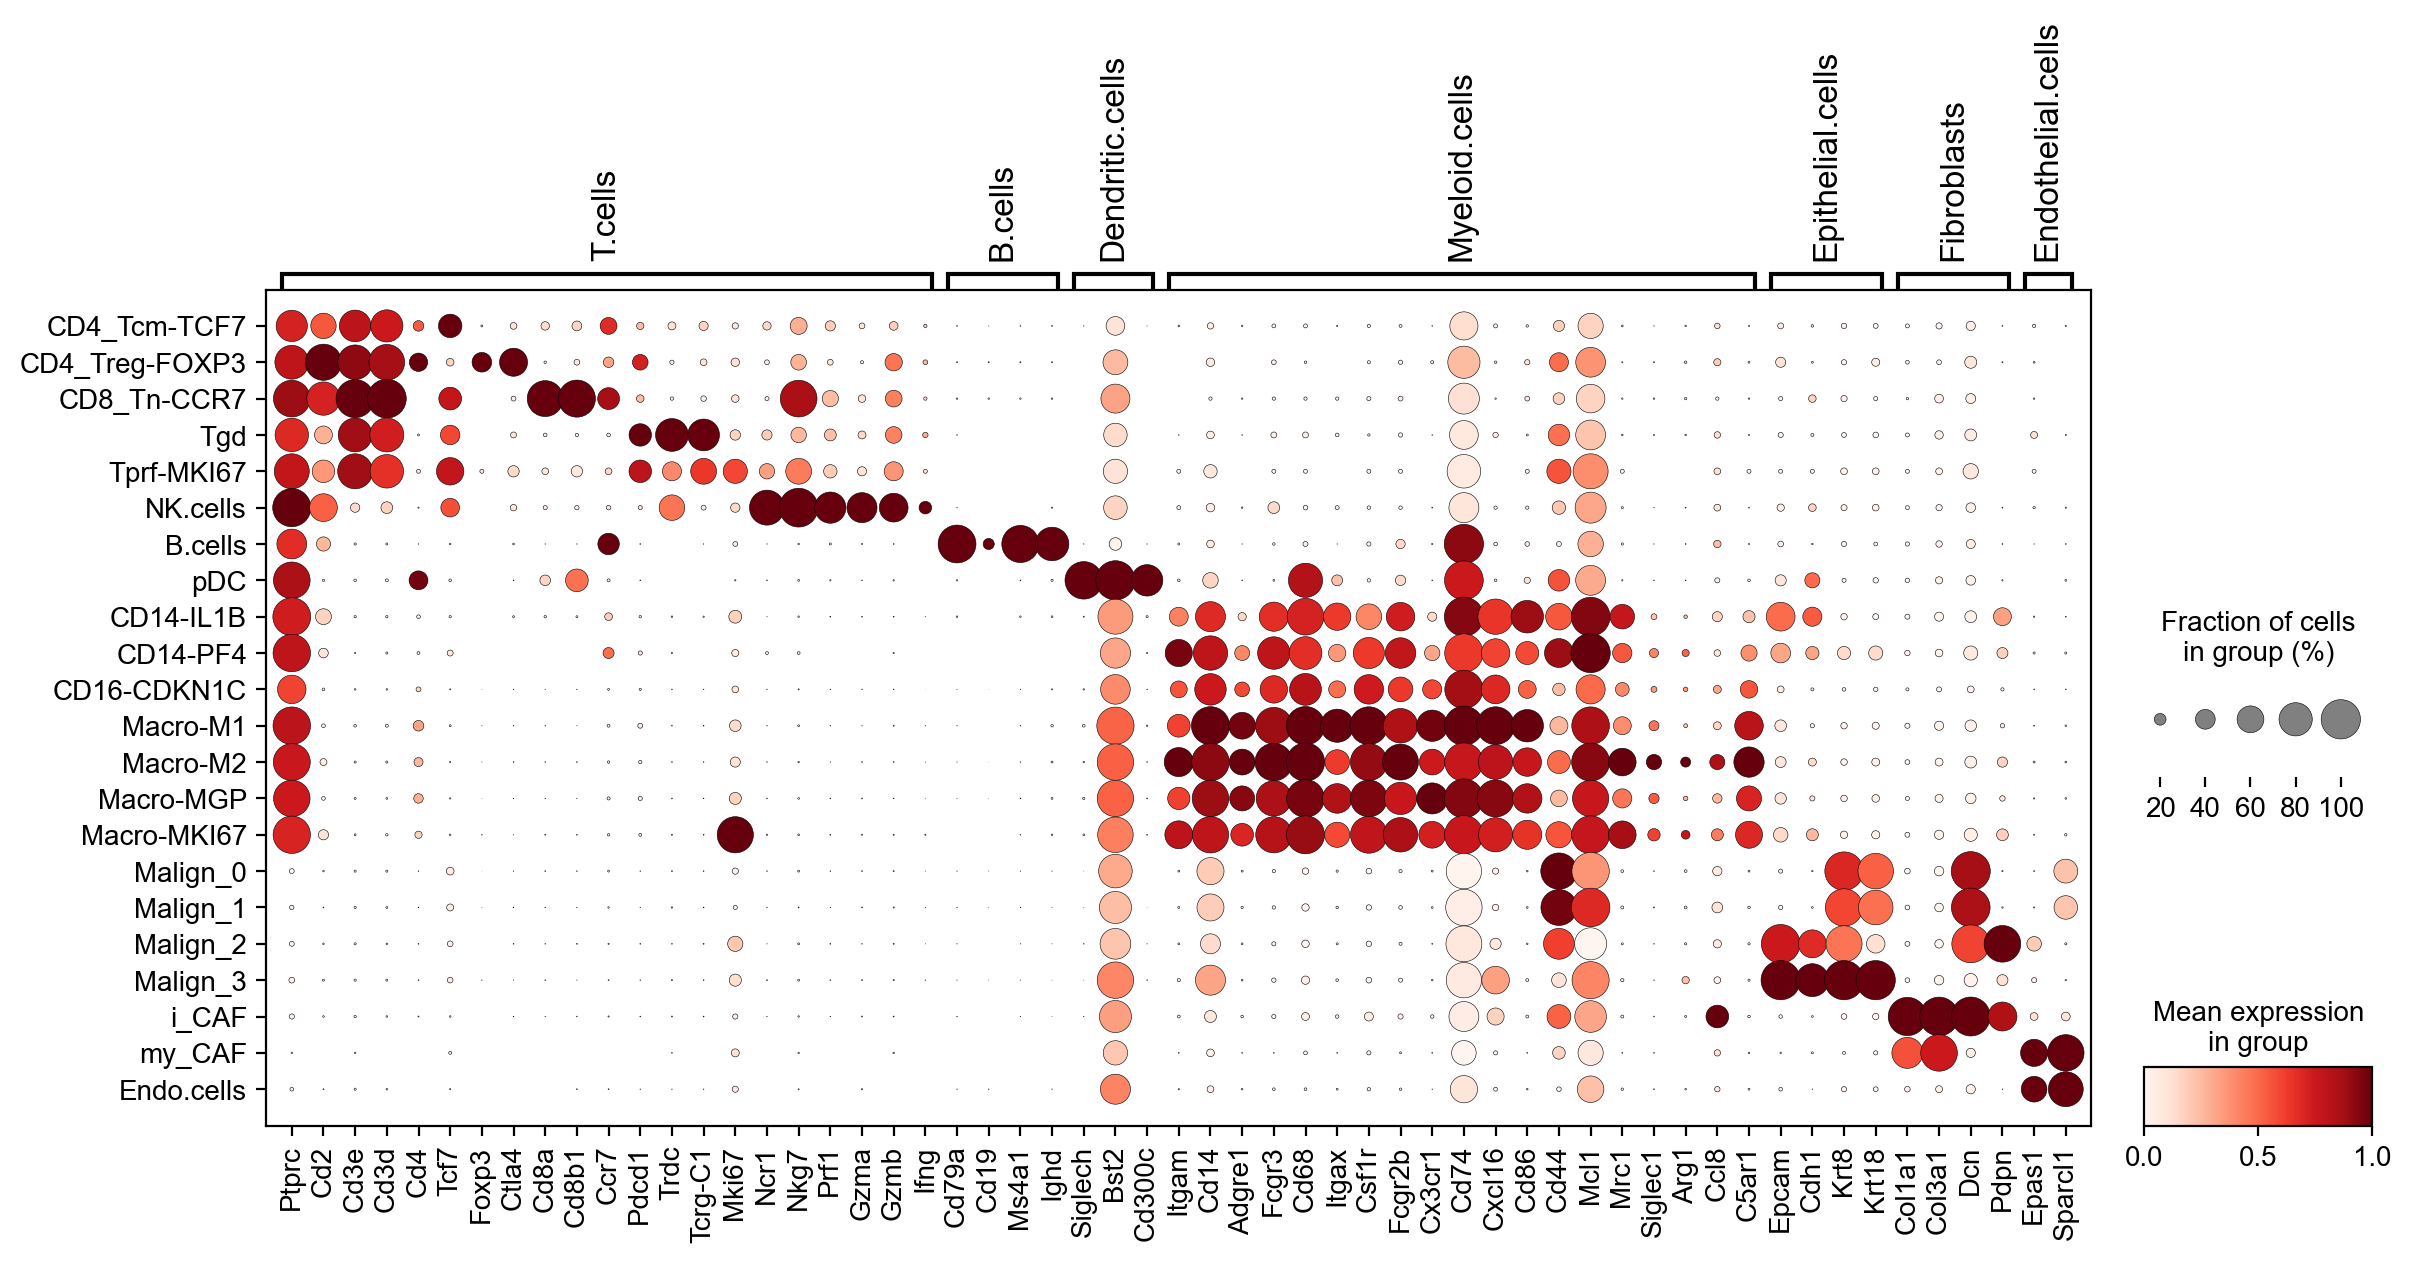

In [90]:
#sc.tl.dendrogram(adata,groupby="anno_clusters10")
markers ={
    "T.cells":["Ptprc","Cd2","Cd3e","Cd3d","Cd4","Tcf7","Foxp3","Ctla4","Cd8a","Cd8b1","Ccr7","Pdcd1","Trdc","Tcrg-C1","Mki67","Ncr1","Nkg7","Prf1","Gzma","Gzmb","Ifng"],
    "B.cells":["Cd79a","Cd19","Ms4a1","Ighd"],
    "Dendritic.cells":["Siglech","Bst2","Cd300c"],
    "Myeloid.cells":["Itgam","Cd14","Adgre1","Fcgr3","Cd68","Itgax","Csf1r","Fcgr2b","Cx3cr1", "Cd74","Cxcl16","Cd86",
                     "Cd44","Mcl1","Mrc1","Siglec1","Arg1","Ccl8","C5ar1"],
     "Epithelial.cells":["Epcam","Cdh1","Krt8","Krt18"],   
    "Fibroblasts":["Col1a1","Col3a1","Dcn","Pdpn"],
    "Endothelial.cells":["Epas1","Sparcl1"],
   
    }

sc.pl.dotplot(adata, markers,standard_scale="var",cmap="Reds"
              ,figsize=(13.5,5.5),
                     mean_only_expressed=False, expression_cutoff=0,
                     groupby='anno_clusters', dendrogram=False,save=f"{project_ID}_markers_Myeloid.pdf")

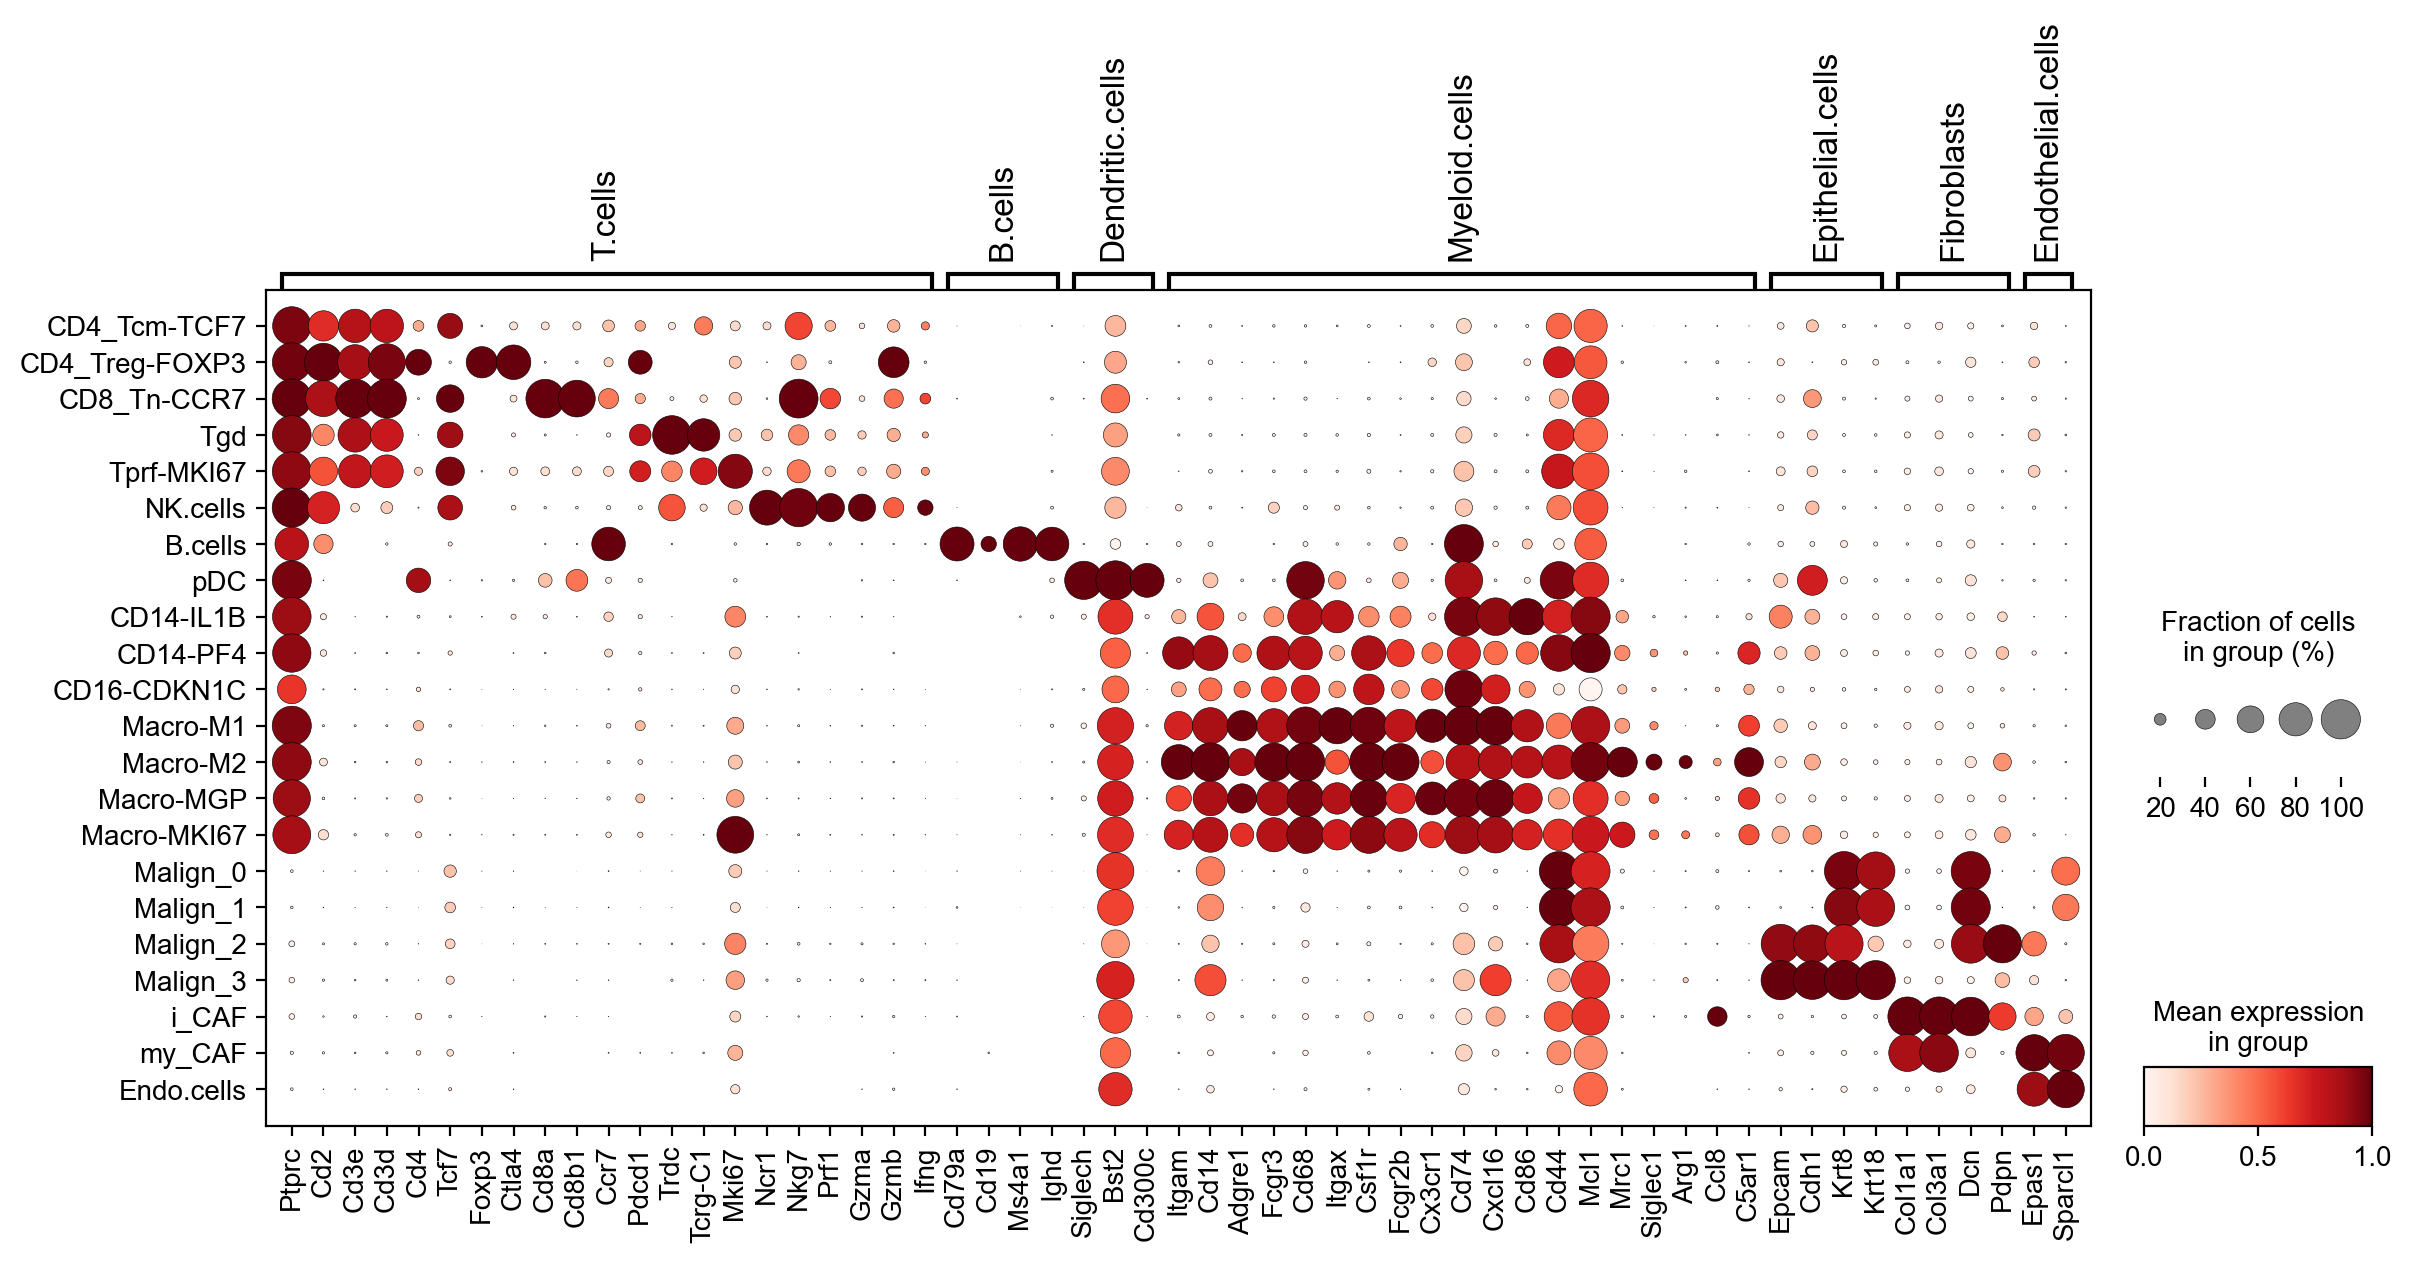

In [28]:
#sc.tl.dendrogram(adata,groupby="anno_clusters10")
markers ={
    "T.cells":["Ptprc","Cd2","Cd3e","Cd3d","Cd4","Tcf7","Foxp3","Ctla4","Cd8a","Cd8b1","Ccr7","Pdcd1","Trdc","Tcrg-C1","Mki67","Ncr1","Nkg7","Prf1","Gzma","Gzmb","Ifng"],
    "B.cells":["Cd79a","Cd19","Ms4a1","Ighd"],
    "Dendritic.cells":["Siglech","Bst2","Cd300c"],
    "Myeloid.cells":["Itgam","Cd14","Adgre1","Fcgr3","Cd68","Itgax","Csf1r","Fcgr2b","Cx3cr1", "Cd74","Cxcl16","Cd86",
                     "Cd44","Mcl1","Mrc1","Siglec1","Arg1","Ccl8","C5ar1"],
     "Epithelial.cells":["Epcam","Cdh1","Krt8","Krt18"],   
    "Fibroblasts":["Col1a1","Col3a1","Dcn","Pdpn"],
    "Endothelial.cells":["Epas1","Sparcl1"],
   
    }

sc.pl.dotplot(adata, markers,standard_scale="var",cmap="Reds"
              ,figsize=(13.5,5.5),
                     mean_only_expressed=False, expression_cutoff=0,
                     groupby='anno_clusters', dendrogram=False,save=f"{project_ID}_markers_T.pdf")

In [ ]:
anno=pd.Series("unknown", index=adata.obs_names)
anno[adata.obs.cell_type!="x"]=adata[adata.obs.cell_type!="x"].obs.anno_clusters
anno[adata.obs.anno_clusters.str.startswith("Macro-MGP")]="Macro-others"

In [ ]:
adata.obs["anno_clusters"]=adata.obs["anno_clusters2"]

In [ ]:
#plot umap grouped by treatment
plot_pattern="anno_clusters"
scv.pl.scatter(adata, save=f"{plot_pattern}_umap.pdf",
               basis="umap",
           color=plot_pattern,legend_loc="right",
            size=20, alpha=0.8,
            palette=[ "coral",
                     "DeepSkyBlue","slategrey","PeachPuff","gold","crimson",
                     "SpringGreen","olivedrab","orchid",
                     "lightcoral","firebrick","Pink", "tan",
                   "MidnightBlue", "DarkMagenta", "darkviolet","royalblue", 
                   "RosyBrown","Goldenrod","BurlyWood","Peru",
            "Thistle","lightseagreen","CadetBlue",
            "lightsteelblue","dimgrey","black","IndianRed","PaleVioletRed","hotpink","greenyellow","forestgreen","PaleTurquoise","Aqua",] )

In [ ]:
#plot umap grouped by treatment
plot_pattern="RSR_clusters"
scv.pl.scatter(adata, save=f"{plot_pattern}_umap.pdf",
               basis="umap",
           color=plot_pattern,legend_loc="right",
            size=20, alpha=0.8,
            palette=[ "coral",
                     "DeepSkyBlue","slategrey","PeachPuff","gold","crimson",
                     "SpringGreen","olivedrab","orchid",
                     "lightcoral","firebrick","Pink", "tan",
                   "MidnightBlue", "DarkMagenta", "darkviolet","royalblue", 
                   "RosyBrown","Goldenrod","BurlyWood","Peru",
            "Thistle","lightseagreen","CadetBlue",
            "lightsteelblue","dimgrey","black","IndianRed","PaleVioletRed","hotpink","greenyellow","forestgreen","PaleTurquoise","Aqua",] )

In [ ]:
 markers={
    "Class Ia":[genes for genes in ['H2-K1','H2-Ke6', 'H2-D1',] if genes in adata.var_names],
    "Class Ib":[genes for genes in['H2-T24', 'H2-T23','H2-T22','H2-T3','H2-Q1', 'H2-Q2', 'H2-Q4', 'H2-Q6', 'H2-Q7', 'H2-Q10', ]if genes in adata.var_names],
    "Class II":[genes for genes in[  'H2-Aa',  'H2-M10.2', 'H2-M10.1', 'H2-M10.3',
         'H2-M10.4','H2-M9', 'H2-M1','H2-M5','H2-M2', 'H2-Oa', 'H2-DMa', 'H2-DMb2', 'H2-DMb1','H2-Ob', 'H2-Ab1', 'H2-Eb1', 'H2-Eb2',
         'H2-M11', 'H2-M10.5', 'H2-M10.6', 'H2-M3']if genes in adata.var_names]
}
sc.pl.dotplot(adata, markers ,cmap="jet",standard_scale="var",
                     mean_only_expressed=False, expression_cutoff=0,use_raw=False,
                     groupby='anno_clusters', dendrogram=False,save=f"{project_ID}_MHC_treatments_anno_clusters.pdf")

In [ ]:

markers ={
    "Myeloid.cells":["Itgam","Fcgr3"],
    "MDSCs":["Ly6g","Ly6c1","Ly6c2","Lin28a","Cd33","Fut4"],
    "Monocytes":["Cd14","Cd300a","F13a1","Hp","Vcan"],
    "Macrophages":["Lyz2","Cd68","Csf1r","Adgre1","C1qa","C1qb","C1qc"],
    "TREM":["Trem1","Trem2"],
    "M1_TAM":["Cd86","Cx3cr1","Cxcl16",],
    "M2_TAM":["Mrc1","Siglec1","C5ar1"],
    "Microglia":["Tmem119","P2ry12"],
    "Immune_checkpoint":["Cd274","Cd80"],
    "MHC-II":['H2-K1','H2-Aa','H2-T23','H2-M5', 'H2-M2','H2-Oa','H2-DMb2','H2-Ob' ,'H2-Ab1', 'H2-Eb2', 'H2-D1','H2-Q7',]
}

sc.pl.dotplot(adata[adata.obs.treatment.str.startswith("T22_V")], markers,standard_scale="var",cmap="RdYlBu_r",
                     mean_only_expressed=False, expression_cutoff=0,use_raw=True,
                     groupby='anno_clusters2', dendrogram=False,save=f"{project_ID}_clusters.pdf")

In [ ]:
sc.pl.dotplot(adata, [genes for genes in pro_tumor_cytokine if genes in adata.var_names], groupby="RSR_sample", use_raw=False, layer="spliced", standard_scale="var", cmap="jet")#, rotation=90)

In [ ]:
gene="C5ar1"
sc.pl.dotplot(adata[(adata.obs.anno_clusters.str.startswith("Macro-M1"))&(adata.obs.treatment.str.startswith("T127"))], [gene], groupby="treatment", 
                 use_raw=True,save=f"{project_ID}_{gene}.pdf",
                 figsize=(8,3))#,rotation=90)

In [ ]:
gene="C5ar1"
sc.pl.dotplot(adata[(adata.obs.anno_clusters.str.startswith("Macro-M1"))&(adata.obs.treatment.str.startswith("T22"))], [gene], groupby="treatment", 
                 use_raw=True,save=f"{project_ID}_{gene}.pdf",
                 figsize=(8,3))#,rotation=90)

In [ ]:
gene=["Csf1r","C5ar1","Cx3cr1"]
sc.pl.dotplot(adata[adata.obs.anno_clusters=="Macro-M1"], gene, groupby="treatment", standard_scale="var",
                 use_raw=True,
              save=f"{project_ID}_{gene}_M1.pdf",
              cmap="jet",#dendrogram=True,
                 figsize=(2.7,2.2))#,rotation=90)

In [ ]:
gene=["Csf1r","C5ar1","Cx3cr1"]
sc.pl.dotplot(adata[(adata.obs.anno_clusters=="Macro-M2")], gene, groupby="treatment", standard_scale="var",
                 use_raw=True,
              #save=f"{project_ID}_{gene}.pdf",
              cmap="jet",#dendrogram=True,
                 figsize=(2.7,1.8))#,rotation=90)

In [ ]:
gene=["Il34","Csf1","Rps19","Cx3cl1"]
sc.pl.dotplot(adata[(adata.obs.treatment.str.startswith("T22"))&(adata.obs.RSR_group=="RSR")], gene, groupby="treatment", standard_scale="var",
                 use_raw=True,
              #save=f"{project_ID}_{gene}.pdf",
              cmap="jet",#dendrogram=True,
                 figsize=(2.7,1.4))#,rotation=90)

In [ ]:
gene=["Il34","Csf1","Rps19","Cx3cl1"]
sc.pl.dotplot(adata[(adata.obs.treatment.str.startswith("T127"))], gene, groupby="treatment", standard_scale="var",
                 use_raw=True,
              #save=f"{project_ID}_{gene}.pdf",
              cmap="jet",#dendrogram=True,
                 figsize=(2.7,1.4))#,rotation=90)

In [ ]:
gene=["Reactome_IFNG_mm_score"]
sc.pl.dotplot(adata[adata.obs.treatment.str.startswith("T22")], gene, groupby="RSR_sample_brf", standard_scale="var",
                 use_raw=True,save=f"{project_ID}_{gene}_T22.pdf",cmap="jet",#dendrogram=True,
                 figsize=(2.7,2.2))#,rotation=90

In [ ]:
adata.obs["treatment_cluster"]=adata.obs["treatment"].astype(str)+"_"+adata.obs["clusters"].astype(str)

In [ ]:
gene=["Reactome_IFNG_mm_score"]
sc.pl.violin(adata[adata.obs.treatment.str.startswith("T127")], gene, groupby="RSR_sample_brf", standard_scale="var",
                 use_raw=True,save=f"{project_ID}_{gene}_T127.pdf",cmap="jet",#dendrogram=True,
                 figsize=(2.7,2.2))#,rotation=90

In [ ]:
gene=["Il34","Csf1","Rps19","Cx3cl1"]
sc.pl.dotplot(adata, gene, groupby="treatment2", standard_scale="var",
                 use_raw=True,#save=f"{project_ID}_{gene}_RSRD_T22.pdf",cmap="jet",#dendrogram=True,
                 figsize=(2.7,6))#,rotation=90)

In [ ]:
gene="Rps19"
sc.pl.dotplot(adata[(adata.obs.anno_clusters.str.startswith("Malign"))&(adata.obs.treatment.str.startswith("T22"))], [gene], groupby="treatment", 
                 use_raw=True,save=f"{project_ID}_{gene}.pdf",
                 figsize=(8,3))#,rotation=90)

In [ ]:

markers ={
    "Myeloid.cells":["Itgam","Fcgr3"],
    "MDSCs":["Ly6g","Ly6c1","Ly6c2","Lin28a","Cd33","Fut4"],
    "Monocytes":["Cd14","Cd300a","F13a1","Hp","Vcan"],
    "Macrophages":["Lyz2","Cd68","Csf1r","Adgre1","C1qa","C1qb","C1qc"],
    "TREM":["Trem1","Trem2"],
    "M1_TAM":["Cd86","Cx3cr1","Cxcl16",],
    "M2_TAM":["Mrc1","Siglec1","C5ar1"],
    "Microglia":["Tmem119","P2ry12"],
    "Immune_checkpoint":["Cd274","Cd80"],
    "MHC-II":['H2-K1','H2-Aa','H2-T23','H2-M5', 'H2-M2','H2-Oa','H2-DMb2','H2-Ob' ,'H2-Ab1', 'H2-Eb2', 'H2-D1','H2-Q7',]
}

sc.pl.dotplot(adata[adata.obs.Sample_ID.str.startswith("T22coo")], markers,standard_scale="var",cmap="RdYlBu_r",
                     mean_only_expressed=False, expression_cutoff=0,
                     groupby='anno_clusters', dendrogram=False,save=f"{project_ID}_clusters.pdf")

In [ ]:

markers ={
    "Myeloid.cells":["Itgam","Fcgr3"],
    "MDSCs":["Ly6g","Ly6c1","Ly6c2","Lin28a","Cd33","Fut4"],
    "Monocytes":["Cd14","Cd300a","F13a1","Hp","Vcan"],
    "Macrophages":["Lyz2","Cd68","Csf1r","Adgre1","C1qa","C1qb","C1qc"],
    "TREM":["Trem1","Trem2"],
    "M1_TAM":["Cd86","Cx3cr1","Cxcl16",],
    "M2_TAM":["Mrc1","Siglec1","C5ar1"],
    "Microglia":["Tmem119","P2ry12"],
    "Immune_checkpoint":["Cd274","Cd80"],
    "MHC-II":['H2-K1','H2-Aa','H2-T23','H2-M5', 'H2-M2','H2-Oa','H2-DMb2','H2-Ob' ,'H2-Ab1', 'H2-Eb2', 'H2-D1','H2-Q7',]
}

sc.pl.dotplot(adata, markers,standard_scale="var",cmap="RdYlBu_r",
                     mean_only_expressed=False, expression_cutoff=0,
                     groupby='anno_clusters2', dendrogram=False,save=f"{project_ID}_clusters.pdf")

In [ ]:

markers ={
    "Myeloid.cells":["Itgam","Fcgr3"],
    "MDSCs":["Ly6g","Ly6c1","Ly6c2","Lin28a","Cd33","Fut4"],
    "Monocytes":["Cd14","Cd300a","F13a1","Hp","Vcan"],
    "Macrophages":["Lyz2","Cd68","Csf1r","Adgre1","C1qa","C1qb","C1qc"],
    "TREM":["Trem1","Trem2"],
    "M1_TAM":["Cd86","Cx3cr1","Cxcl16",],
    "M2_TAM":["Mrc1","Siglec1","C5ar1"],
    "Microglia":["Tmem119","P2ry12"],
    "Immune_checkpoint":["Cd274","Cd80"],
    "MHC-II":['H2-K1','H2-Aa','H2-T23','H2-M5', 'H2-M2','H2-Oa','H2-DMb2','H2-Ob' ,'H2-Ab1', 'H2-Eb2', 'H2-D1','H2-Q7',]
}

sc.pl.dotplot(adata[adata.obs.Sample_ID.str.startswith("T22so")], markers,standard_scale="var",cmap="RdYlBu_r",
                     mean_only_expressed=False, expression_cutoff=0,
                     groupby='anno_clusters2', dendrogram=False,save=f"{project_ID}_clusters.pdf")

In [ ]:
#sc.tl.dendrogram(adata,groupby="clusters")
markers ={
    "Endothelial.cells":["Epas1","Sparcl1"],
    "Fibroblasts":["Col1a1","Col3a1","Dcn","Pdpn"],
    "Epithelial.cells":["Epcam","Krt8","Krt18","Rps19"],
    "T.cells":["Ptprc","Cd2","Cd3e","Cd3d","Cd4","Tbx21","Foxp3","Rorc","Cd8a","Cd8b1","Lat","Pdcd1","Gzmb","Cd69","Il2ra"],
    "NK.cells":["Ncam1","Nkg7","Ncr1","Prf1"],
    "B.cells":["Cd79a","Cd19","Ms4a1","Jchain","Ighd","Tnfrsf17","Sdc1"],
    "Myeloid.cells":["Itgam","Fcgr3"],
    "Dendritic.cells":["Itgax","Cd83","Siglech","Bst2","Cd300c"],
    "Monocytes":["Cd14","Lyz2","Cd300a","F13a1","Hp"],
    "Macrophages":["Csf1r","Cd68","Adgre1","Cd86","Mrc1","Cd163"],
    }

sc.pl.stacked_violin(adata, markers,standard_scale="var",cmap="jet",
                     #mean_only_expressed=False, expression_cutoff=0,use_raw=True,
                     groupby='anno_clusters', dendrogram=False,save=f"{project_ID}_markers.pdf")

In [ ]:
T_cells=["Ptprc","Cd3d","Cd3e","Cd4","Cd8a","Cd8b1","Trac","Trdc","Tcrg-C1"]
Cytotoxic=["Nkg7","Prf1","Cst7","Gzma","Gzmb","Gzmk","Ifng","Ifna1","Tnfsf10","Fasl"]
Exhausted=["Ctla4","Lag3","Pdcd1","Tigit"]
Regulatory=["Foxp3","Il2ra","Tgfb1","Tgfb3","Tgfbi","Tgfbr1"]
Naive=["Ccr7","Lef1","Sell","Tcf7","Cd27"]
Co_stimulatory=["Cd226","Icos","Tnfrsf14","Tnfrsf25","Tnfrsf9","Cd27"]
Proliferation=["Mki67","Top2a"]
Apoptosis_Tolerance=["Gadd45b","Rnf128"]
Vip_receptors=["Vipr1","Vipr2"]

In [ ]:
T_cells=[genes for genes in adata.var_names if genes in T_cells]
Cytotoxic=[genes for genes in adata.var_names if genes in Cytotoxic]
Exhausted=[genes for genes in adata.var_names if genes in Exhausted]
Regulatory=[genes for genes in adata.var_names if genes in Regulatory]
Naive=[genes for genes in adata.var_names if genes in Naive]
Co_stimulatory=[genes for genes in adata.var_names if genes in Co_stimulatory]
Proliferation=[genes for genes in adata.var_names if genes in Proliferation]
Apoptosis_Tolerance=[genes for genes in adata.var_names if genes in Apoptosis_Tolerance]
Vip_receptors=[genes for genes in adata.var_names if genes in Vip_receptors]

In [ ]:
#sc.tl.dendrogram(adata,groupby="Sample")
markers ={
    "T.cells":T_cells,
    "Cytotoxic":Cytotoxic,
    "Exhausted":Exhausted,
    "Regulatory":Regulatory,
    "Naive":Naive,
    "Co-stimulatory":Co_stimulatory,
    "Proliferation":Proliferation,
    "Apoptosis&Tolerance":Apoptosis_Tolerance,
    "Vip receptors":Vip_receptors
}

sc.pl.dotplot(adata[adata.obs.anno_clusters=="CD8-CXCL13"], markers,standard_scale="var",cmap="RdYlBu_r",
                     mean_only_expressed=False, expression_cutoff=0, use_raw=True,
                     groupby='treatment', dendrogram=False)#,save=f"{project_ID}_markers_strains.pdf")

In [ ]:
#sc.tl.dendrogram(adata,groupby="Sample")
markers ={
    "T.cells":T_cells,
    "Cytotoxic":Cytotoxic,
    "Exhausted":Exhausted,
    "Regulatory":Regulatory,
    "Naive":Naive,
    "Co-stimulatory":Co_stimulatory,
    "Proliferation":Proliferation,
    "Apoptosis&Tolerance":Apoptosis_Tolerance,
    "Vip receptors":Vip_receptors
}

sc.pl.dotplot(adata[adata.obs.anno_clusters=="CD8_Teff-GNLY"], markers,standard_scale="var",cmap="RdYlBu_r",
                     mean_only_expressed=False, expression_cutoff=0, use_raw=False,
                     groupby='treatment', dendrogram=False)#,save=f"{project_ID}_markers_strains.pdf")

In [ ]:
#sc.tl.dendrogram(adata,groupby="Sample")
markers ={
    "T.cells":T_cells,
    "Cytotoxic":Cytotoxic,
    "Exhausted":Exhausted,
    "Regulatory":Regulatory,
    "Naive":Naive,
    "Co-stimulatory":Co_stimulatory,
    "Proliferation":Proliferation,
    "Apoptosis&Tolerance":Apoptosis_Tolerance,
    "Vip receptors":Vip_receptors
}

sc.pl.dotplot(adata[adata.obs.anno_clusters=="CD8_Tem-GZMK"], markers,standard_scale="var",cmap="RdYlBu_r",
                     mean_only_expressed=False, expression_cutoff=0, use_raw=False,
                     groupby='treatment', dendrogram=False)#,save=f"{project_ID}_markers_strains.pdf")

In [ ]:
Antigen_presentation=list(map(lambda x:x.capitalize(),pd.read_csv(f"/mnt/533ee9c3-18c0-4c72-a09e-d9ce5a10ef9e/sig/Antigen_presentation.csv",header=None, sep=",", usecols=[0],).squeeze().str.strip().tolist()) )
Cytotoxic_effector_functions=list(map(lambda x:x.capitalize(),pd.read_csv(f"/mnt/533ee9c3-18c0-4c72-a09e-d9ce5a10ef9e/sig/Cytotoxic_effector_functions.csv",header=None, sep=",", usecols=[0],).squeeze().str.strip().tolist()) )
Immune_response=list(map(lambda x:x.capitalize(),pd.read_csv(f"/mnt/533ee9c3-18c0-4c72-a09e-d9ce5a10ef9e/sig/Immune_response.csv",header=None, sep=",", usecols=[0],).squeeze().str.strip().tolist()))
Metabolism=list(map(lambda x:x.capitalize(),pd.read_csv(f"/mnt/533ee9c3-18c0-4c72-a09e-d9ce5a10ef9e/sig/Metabolism.csv",header=None, sep=",", usecols=[0],).squeeze().str.strip().tolist()))
Neuroendocrine_like=list(map(lambda x:x.capitalize(),pd.read_csv(f"/mnt/533ee9c3-18c0-4c72-a09e-d9ce5a10ef9e/sig/Neuroendocrine_like.csv",header=None, sep=",", usecols=[0],).squeeze().str.strip().tolist()))
TGFbeta_Stromal_activity=list(map(lambda x:x.capitalize(),pd.read_csv(f"/mnt/533ee9c3-18c0-4c72-a09e-d9ce5a10ef9e/sig/TGFbeta_Stromal_activity.csv",header=None, sep=",", usecols=[0],).squeeze().str.strip().tolist()))
 

In [ ]:
Antigen_presentation=[genes for genes in adata.raw.var_names if genes in Antigen_presentation]
Cytotoxic_effector_functions=[genes for genes in adata.raw.var_names if genes in Cytotoxic_effector_functions]
Immune_response=[genes for genes in adata.raw.var_names if genes in Immune_response]
Metabolism=[genes for genes in adata.raw.var_names if genes in Metabolism]
Neuroendocrine_like=[genes for genes in adata.raw.var_names if genes in Neuroendocrine_like]
TGFbeta_Stromal_activity=[genes for genes in adata.raw.var_names if genes in TGFbeta_Stromal_activity]

In [ ]:
Antigen_presentation=[genes for genes in adata.var_names if genes in Antigen_presentation]
Cytotoxic_effector_functions=[genes for genes in adata.var_names if genes in Cytotoxic_effector_functions]
Immune_response=[genes for genes in adata.var_names if genes in Immune_response]
Metabolism=[genes for genes in adata.var_names if genes in Metabolism]
Neuroendocrine_like=[genes for genes in adata.var_names if genes in Neuroendocrine_like]
TGFbeta_Stromal_activity=[genes for genes in adata.var_names if genes in TGFbeta_Stromal_activity]

In [ ]:
markers={
    "Antigen_presentation":Antigen_presentation,
    "Cytotoxic_effector_functions":Cytotoxic_effector_functions,
    "Immune_response":Immune_response,
    "TGFbeta_Stromal_activity":TGFbeta_Stromal_activity,
    "Metabolism":Metabolism,
    "Neuroendocrine_like":Neuroendocrine_like
}
dendrogram_list= Antigen_presentation+Cytotoxic_effector_functions+Immune_response+Metabolism+Neuroendocrine_like+TGFbeta_Stromal_activity

In [ ]:
#sc.tl.dendrogram(adata,groupby="treatment",cor_method = "pearson",optimal_ordering=True)
sc.pl.matrixplot(adata[adata.obs.anno_clusters.str.startswith("NK")], markers,standard_scale="var",cmap="RdYlBu_r",   use_raw=True,#,  layer="spliced",   
                     groupby='treatment', dendrogram=False,save=f"{project_ID}_markers_spacial_T22_short.pdf")

In [ ]:
old_to_new={
    "1":"Macro_Mono",
    "6":"Macro_Mono",
    "0":"Macro_Mono",
    "7":"Macro_Mono",
    "11":"Macro_Mono",
    
    "3":"T127_Malign",
    "8":"T127_Malign",
    "4":"T127_Malign",
    "5":"T22_Malign_1",
    "10":"T22_Malign_2",
    
    "2":"T.cells",
    "13":"T.cells",

    "9":"Endo_Fibro.cells",
    
    "12":"B.cells"
    
}

In [ ]:
adata.obs["anno_clusters"]=(adata.obs["clusters"].map(old_to_new).astype("category"))

In [ ]:

markers ={
    "ligand":["Fasl"],
    "receptor":["Fas"]
    }

sc.pl.dotplot(adata, markers,standard_scale="var",cmap="RdYlBu_r",
                     mean_only_expressed=False, expression_cutoff=0,
                     groupby='Sample_anno', dendrogram=True,save=f"{project_ID}_markers_anno.pdf")

In [ ]:
#plot umap grouped by treatment
plot_pattern="clusters"
scv.pl.scatter(adata, save=f"{plot_pattern}_umap.pdf",
               basis="umap",
           color=plot_pattern,legend_loc="right",
          palette=[ "DeepSkyBlue","royalblue","MidnightBlue","Pink","hotpink","darkviolet",
                    "SpringGreen","forestgreen","maroon"
            , "gold","orchid","crimson"
            ,"firebrick","olivedrab","lightcoral","greenyellow"
            ,"tan","slategrey","coral","lightseagreen"
            ,"lightsteelblue","lightskyblue","dimgrey",
            "indigo","darkturquoise"],
            size=10, alpha=0.8,
            )

write a h5d

# calculate signature scores

In [ ]:
adata=adata_t

In [8]:
raw=pd.DataFrame(data=adata.raw.X.toarray(), index=adata.obs_names, columns=adata.raw.var_names)

In [ ]:
# read in an example gene list
gene_list_name="Reactome_IFNG_mm"# put the gene list file name here, the gene list file should be a csv file
gene_list = pd.read_csv(f"{SigsDir}/{gene_list_name}.csv",header=None, sep=",", usecols=[0],)
# convert dataframe or series to list
gene_list_ = gene_list.squeeze().str.strip().tolist()
#gene_list_ = [x.capitalize() for x in gene_list_]
#calculate a signature expression score by sc internal function. scv cannot calculate a gene list with coefficient
sc.tl.score_genes(adata, score_name=f"{gene_list_name}_score", gene_list=gene_list_, ctrl_size=50, use_raw=False)

In [ ]:
# read in an example gene list
gene_list_random="random_500_Mm"# put the gene list file name here, the gene list file should be a csv file
random_list = pd.read_csv(f"{SigsDir}/{gene_list_random}.csv",header=None, sep=",", usecols=[0],)
# convert dataframe or series to list
random_list_ = random_list.squeeze().str.strip().tolist()
random_list_ = [x.capitalize() for x in random_list_]
random_list_=[genes for genes in random_list_ if genes in adata.to_df(layer="spliced").columns]

In [ ]:
# we can also make a gene list here manuallly and then calculate a signature s
asymm=["ACTR3","ACTR2","RGS14","RAB10","ETV5","FGF13","ASPM","GOLGA2","STRA8","ING2","INSC","PAX6","POU5F1",
       "PARD3","SOX5","TEAD3","WNT9B","ZBTB16","DOCK7","ARHGEF2",]
sc.tl.score_genes(adata, score_name="asymmetric_division score", gene_list=asymm, ctrl_size=100)

In [ ]:
# we can also make a gene list here manuallly and then calculate a signature s
dysf=["CXCR6", "ITGAE" ,"DGKH" ,"PHLDA1" ,"MIR155HG", "SLA" ,"TOX2","CCL3", "CXCL13", "PAG1", "CD27",
       "RAB27A", "TRAF5", "SNAP47", "KIR2DL4", "TNFRSF1B", "RDH10" ,"FAM3C" ,"CD7", "IFNG", "CSF1", 
      "TNS3", "CTLA4", "ENTPD1", "PTMS", "AKAP5", "LYST", "PDCD1", "LAG3", "HAVCR2"]
dysf = [ x.capitalize() for x in dysf]
sc.tl.score_genes(adata, score_name="dysfunctional score", gene_list=dysf, ctrl_size=50, use_raw=False)

In [ ]:
# we can also make a gene list here manuallly and then calculate a signature s
cyto=["KLRG1","IL7R","GNLY","SELL","TYROBP","TRDC","SAMD3","FCRL6","CCND3","BIN2","ARL4C","EMP3","ORL1","C1orf162","STK38","EFHD2","FAM65B",
     "S1PR1","CD300A","SPON2","KLRF1","FGR","PLEK","TGFBR3","C1orf21","PLAC8","FCGR3A","S1PR5","FGFBP2","CX3CR1"]
cyto = [ x.capitalize() for x in cyto]
sc.tl.score_genes(adata, score_name="cytotoxic score", gene_list=cyto, ctrl_size=50, use_raw=False)

In [ ]:
# we can also make a gene list here manuallly and then calculate a signature s
Fcg= np.append([x for x in adata.raw.var_names if x.startswith("Fcg")],[x for x in adata.raw.var_names if x.startswith("Fcr")])
sc.tl.score_genes(adata, score_name="Fcg score", gene_list=Fcg, ctrl_size=10, use_raw=False)

In [ ]:
"CCL1","CCL11","CCL17","CCL2","CCL22","CCL24","CCL3",
         "CCL4","CCL5","CCL6","CCL7","CCL8","CD40LG","CD70","CLCF1","CX3CL1","CXCL10",
         "CXCL12","CXCL13","CXCL16","CXCL9","IFNB1","IFNG","CSF2","CSF3",
         "IL10","IL11","IL13","IL15","IL16","IL17A","IL17F",
         "IL20","IL21","IL22","IL23A", "IL12B","IL25","IL3","IL31","IL33",
         "IL34","IL4","IL5","IL6","IL1F8","IL1F9","IL1F5","LGALS1","LIF","LTA","OSM","PDGFB",
         "PDGFC","SHH","TGFB1","TGFB2","TNF","TNFSF11","TNFSF13","TNFSF13B","TNFSF8","TNFSF9",

In [ ]:
# we can also make a gene list here manuallly and then calculate a signature s
chemotaxis=["CXCL12","CX3CL1","CCL19", "CCL21", "CXCL10"," CXCL11", " CXCL12","CCL2", "CCL3"," CCL4", "CCL5", "CCL10","IL1A","IL1B","IL2","IL12A","IL12A","IL12B","IL12B",]
chemotaxis= [ x.capitalize() for x in chemotaxis]
sc.tl.score_genes(adata, score_name="chemotaxis score", gene_list=chemotaxis, ctrl_size=10, use_raw=False)

In [ ]:
# we can also make a gene list here manuallly and then calculate a signature s
glist= Antigen_presentation+Cytotoxic_effector_functions+Immune_response+Metabolism
sc.tl.score_genes(adata, score_name="immune infiltration score", gene_list=glist, ctrl_size=50 ,use_raw=True)

In [ ]:
# we can also make a gene list here manuallly and then calculate a signature s
glist= np.append([genes for genes in adata.var_names if genes.startswith("Cdk")],[genes for genes in adata.var_names if genes.startswith("Ccn")])
sc.tl.score_genes(adata, score_name="Cyclin score", gene_list=glist, ctrl_size=10 ,use_raw=False)

In [ ]:
# we can also make a gene list here manuallly and then calculate a signature s
anti_tumor_cytokine=["Il1b","Il2","Il12b","1l1a","Tnf","Cxcl9","Cxcl10","Ifng",]
sc.tl.score_genes(adata_t, score_name="antitumor_cytokine_score", gene_list=anti_tumor_cytokine, ctrl_size=10, use_raw=False)

In [ ]:
# we can also make a gene list here manuallly and then calculate a signature s
pro_tumor_cytokine=["Il10","Tgfb1","Ccl17","Ccl3","Ccl22","Ccl24","Ccl2","Vegfa","Il4","Cxcl15","Cxcl1","Cxcl2","Cxcl3",]
sc.tl.score_genes(adata_t, score_name="protumor_cytokine_score", gene_list=pro_tumor_cytokine, ctrl_size=20, use_raw=False)

In [ ]:
gene_list_name="Reactome_IFNG_mm"
gene_list_coe_=pd.read_csv(f"{SigsDir}/{gene_list_name}.csv",header=1, sep=",",usecols=[0,1],index_col=0)
gene_list_coe_=[genes.capitalize() for genes in gene_list_coe.index if genes.capitalize() in adata.to_df(layer="spliced").columns]

In [ ]:
X_score=0
for genes in gene_list_coe_:
    X_score=X_score+adata.to_df(layer="Ms").loc[:,genes]/len(gene_list_coe_)
for genes in random_list_:
    X_score=X_score-adata.to_df(layer="Ms").loc[:,genes]/len(random_list_)
adata.obs[f"Reactome_IFNG_mm_score"]=X_score

In [ ]:
X_score=0
for genes in gene_list_coe_:
    X_score=X_score+gene_list_coe.loc[genes.upper()].values[0]*adata.to_df(layer="spliced").loc[:,genes]
for genes in random_list_:
    X_score=X_score-adata.to_df(layer="spliced").loc[:,genes]
adata.obs["RSR_score"]=X_score

In [ ]:
adata.obs["immune_infiltration_score"]=adata.obs["immune infiltration score"].astype(float)-adata.obs["TGFb score"].astype(float)

In [ ]:
for i in np.unique(adata.obs.RSR_sample):
    var=pd.DataFrame(raw["Cx3cl1"], index=adata[adata.obs.RSR_sample==i].obs_names)
    var.columns=[i]
    var.to_csv(f"{project_ID}_DEG/{i}_RSR_sample_Cx3cl1.csv", header=i)

In [ ]:
for i in np.unique(adata.obs.RSR_sample_brf):
    var=pd.DataFrame(adata[adata.obs.RSR_sample_brf==i].obs["MM_IFNG_score"], index=adata[adata.obs.RSR_sample_brf==i].obs_names)
    var.columns=[i]
    var.to_csv(f"{project_ID}_DEG/{i}_RSR_brf_MM_IFNG.csv", header=i)

In [ ]:
raw=pd.DataFrame(data=adata.raw.X.toarray(), index=adata.obs_names, columns=adata.raw.var_names)

In [ ]:
adata.obs["RSR_sample_brf"]=adata.obs["RSR_group"].astype(str)+"_"+adata.obs["treatment"].astype(str)

In [ ]:
# read in an example gene list
gene_list_name="MM_IFNG"# put the gene list file name here, the gene list file should be a csv file
gene_list = pd.read_csv(f"{SigsDir}/{gene_list_name}.csv",header=None, sep=",", usecols=[0],)
# convert dataframe or series to list
gene_list_ = gene_list.squeeze().str.strip().tolist()
#gene_list_ = [x.capitalize() for x in gene_list_]
#calculate a signature expression score by sc internal function. scv cannot calculate a gene list with coefficient
sc.tl.score_genes(adata, score_name=f"{gene_list_name}_score", gene_list=gene_list_, ctrl_size=30, use_raw=False)

In [ ]:
sc.pl.violin(adata, "MM_IFNG_score",#layer="spliced",
             use_raw=True,
             groupby="RSR_sample_brf",#save=f"Inflammatory_score.pdf",
            rotation=90, dendrogram=False)

In [ ]:
sc.pl.dotplot(adata, ["Csf1","Il34","Rps19","Cx3cl1"],standard_scale="var",cmap="jet",
              #layer="spliced",
             #use_raw=False,
             groupby="treatment",save=f"cytokine_long.pdf")#,rotation=90, dendrogram=False)

In [ ]:
sc.pl.dotplot(adata[(adata.obs.treatment.str.startswith("T22"))], 
             ["reactome_phagocytosis_score"], 
             groupby="Sample_anno",#save=f"Sample_anno_antigen_presentation.pdf",
             #rotation=90, 
              dendrogram=False, figsize=(2,12))

In [ ]:
#overlap signature or gene expression in umap
color_name=["Col1a1","Pdpn","Col3a1","Ly6c2",
            "Epcam","Krt8","Krt18","Dcn","Cd14",
            "Ptprc","Cd36","Lyz2","Nkg7","Cd2",
            "Cd27","Cd3e","Cd3d","Cd4","Ccr7"]
scv.pl.scatter(adata,basis="umap",use_raw=False,
               color=color_name, #layer="unspliced",
               alpha=0.6,size=2, color_map="coolwarm",
               smooth=5, perc=[2, 98],ncols=4
               ,save=f"featureplot_98_2.pdf")

In [ ]:
#overlap signature or gene expression in umap
color_name=["Epcam","Col1a1","Epas1",
            ]
scv.pl.scatter(adata,basis="umap",use_raw=True,
               color=color_name, #layer="unspliced",
               alpha=0.6,size=5, color_map="jet",
               smooth=50, perc=[2, 98],ncols=3
               ,save=f"featureplot_98_2.pdf")

In [ ]:
#overlap signature or gene expression in umap
color_name=["C5ar1","Csf1r","Mrc1","Mcl1","H2-Ab1","H2-Aa","Itga4"]
scv.pl.scatter(adata,basis="umap",use_raw=False,
               color=color_name, layer="spliced",
               alpha=0.6,size=5, color_map="jet",
               smooth=50, perc=[2, 98],ncols=4
               ,save=f"featureplot2_98_2.pdf")

In [ ]:
#overlap signature or gene expression in umap
color_name=["Ptprc","Cd3e","Cd8a",
            ]
scv.pl.scatter(adata,basis="umap",use_raw=True,
               color=color_name, #layer="unspliced",
               alpha=0.6,size=5, color_map="jet",
               smooth=50, perc=[2, 98],ncols=3
               ,save=f"featureplot2_98_2.pdf")

In [ ]:
#overlap signature or gene expression in umap
color_name=["Cd4","Cd14", "Fcgr3"]
scv.pl.scatter(adata,basis="umap",use_raw=True,
               color=color_name, #layer="unspliced",
               alpha=0.6,size=5, color_map="jet",
               smooth=50, perc=[2, 98],ncols=3
               ,save=f"featureplot4_98_2.pdf")

In [ ]:
#overlap signature or gene expression in umap
color_name="phase"
scv.pl.scatter(adata_22,basis="umap",#use_raw=True,
               color=color_name, #layer="spliced",
               alpha=0.6,size=20, palette=["hotpink","azure","azure"],
               smooth=20, perc=[2, 98],figsize=(1.5, 2.25)
              ,save=f"{color_name}_98_2_22.pdf")

In [ ]:
#overlap signature or gene expression in umap
color_name="phase"
scv.pl.scatter(adata_22,basis="umap",#use_raw=True,
               color=color_name, #layer="spliced",
               alpha=0.6,size=20, palette=["azure","royalblue","azure"],
               smooth=20, perc=[2, 98],figsize=(1.5, 2.25)
              ,save=f"{color_name}_98_2_T22_G2M.pdf")

In [ ]:
#overlap signature or gene expression in umap
color_name="phase"
scv.pl.scatter(adata_22,basis="umap",#use_raw=True,
               color=color_name, #layer="spliced",
               alpha=0.6,size=20, palette=["azure","azure","coral"],
               smooth=20, perc=[2, 98],figsize=(1.5, 2.25)
              ,save=f"{color_name}_98_2_T22_S.pdf")

In [ ]:
adata.obs.columns

In [ ]:
#overlap signature or gene expression in umap
color_name="MM_IFNG_score"
scv.pl.scatter(adata,basis="umap",use_raw=True,
               color=color_name,# layer="spliced",
               alpha=0.6,size=20, color_map="jet",
               smooth=20, perc=[2, 98]#,figsize=(2, 2)
              ,save=f"{color_name}_98_2.pdf")

In [ ]:
#overlap signature or gene expression in umap
color_name="Rps26"
scv.pl.scatter(adata[adata.obs.treatment.str.startswith("T127")],basis="umap",use_raw=False,
               color=color_name, layer="spliced",
               alpha=0.6,size=30, color_map="jet",
               smooth=20, perc=[2, 98],ncols=4
              ,save=f"{color_name}_98_2.pdf")

In [ ]:
#overlap signature or gene expression in umap
color_name="Rps19"
scv.pl.scatter(adata,basis="umap",use_raw=True,
               color=color_name, #layer="spliced",
               alpha=0.6,size=30, color_map="jet",
               smooth=20, perc=[2, 98],ncols=4
              ,save=f"{color_name}_98_2.pdf")

In [ ]:
#overlap signature or gene expression in umap
color_name="Hallmark_inflammatory_score"
scv.pl.scatter(adata,basis="umap",use_raw=True,
               color=color_name, #layer="unspliced",
               alpha=0.6,size=20, color_map="jet",#figsize=(1.5,2.25),
               smooth=20, perc=[2, 98],ncols=4
              ,save=f"{color_name}_98_2_T22.pdf")

In [ ]:
#overlap signature or gene expression in umap
color_name="RSR_group"
scv.pl.scatter(adata,basis="umap",use_raw=True,
               color=color_name, #layer="unspliced",
               alpha=0.6,size=20, color_map="jet",#figsize=(2,2),
               smooth=20, perc=[2, 98],ncols=4
              )#save=f"{color_name}_98_2_T127.pdf")

In [ ]:
adata.obs["RSR_sample"]=adata.obs["RSR_clusters"].astype(str)+"_"+adata.obs["treatment"].astype(str)

In [ ]:
anno=pd.Series("Malign", index=adata.obs_names)
anno[(adata.obs["RSR_score"]>adata[adata.obs.treatment.str.startswith("T22")].obs["RSR_score"].mean())&(adata.obs.phase=="G2M")]="G2M_RSRD"
anno[(adata.obs["RSR_score"]>adata[adata.obs.treatment.str.startswith("T22")].obs["RSR_score"].mean())&(adata.obs.phase=="S")]="S_RSRD"
anno[(adata.obs["RSR_score"]>adata[adata.obs.treatment.str.startswith("T22")].obs["RSR_score"].mean())&(adata.obs.phase=="G1")]="G1_RSRD"
anno[(adata.obs["RSR_score"]<adata[adata.obs.treatment.str.startswith("T22")].obs["RSR_score"].mean())&(adata.obs.phase=="G2M")]="G2M_RSR"
anno[(adata.obs["RSR_score"]<adata[adata.obs.treatment.str.startswith("T22")].obs["RSR_score"].mean())&(adata.obs.phase=="S")]="S_RSR"
anno[(adata.obs["RSR_score"]<adata[adata.obs.treatment.str.startswith("T22")].obs["RSR_score"].mean())&(adata.obs.phase=="G1")]="G1_RSR"
adata.obs["RSR_clusters"]=anno.values

In [ ]:
anno=pd.Series("Malign", index=adata.obs_names)
anno[(adata.obs["RSR_score"]>adata[adata.obs.treatment.str.startswith("T22")].obs["RSR_score"].mean())&(adata.obs.phase=="G2M")]="RSRD"
anno[(adata.obs["RSR_score"]>adata[adata.obs.treatment.str.startswith("T22")].obs["RSR_score"].mean())&(adata.obs.phase=="S")]="RSRD"
anno[(adata.obs["RSR_score"]>adata[adata.obs.treatment.str.startswith("T22")].obs["RSR_score"].mean())&(adata.obs.phase=="G1")]="RSRD"
anno[(adata.obs["RSR_score"]<adata[adata.obs.treatment.str.startswith("T22")].obs["RSR_score"].mean())&(adata.obs.phase=="G2M")]="RSR"
anno[(adata.obs["RSR_score"]<adata[adata.obs.treatment.str.startswith("T22")].obs["RSR_score"].mean())&(adata.obs.phase=="S")]="RSR"
anno[(adata.obs["RSR_score"]<adata[adata.obs.treatment.str.startswith("T22")].obs["RSR_score"].mean())&(adata.obs.phase=="G1")]="RSR"
adata.obs["RSR_group"]=anno.values

In [ ]:
#overlap signature or gene expression in umap
color_name=[genes for genes in adata.var_names if genes.startswith("Cdk")]
scv.pl.scatter(adata,basis="umap",use_raw=False,
               color=color_name, layer="spliced",
               alpha=0.6,size=50, color_map="jet",
               smooth=20, perc=[2, 98],ncols=4
              )#,save=f"{color_name}_98_2.pdf")

In [ ]:
#overlap signature or gene expression in umap
color_name="RSR_sample"
scv.pl.scatter(adata,basis="umap",use_raw=False,
               color=color_name, #layer="spliced",
               alpha=0.6,size=20, color_map="jet",
               smooth=20, perc=[2, 98],ncols=4
              )#,save=f"{color_name}_98_2.pdf")

In [ ]:
#plot velocity and expression plots of each gene in the gene list
scv.pl.velocity(adata,asymm, ncols=2,
                #save="gene_seleted_merge.pdf", 
                basis="umap", color="clusters", figsize=(7,6)
               )

## load scores from GSVA

In [ ]:
score_df=pd.read_csv(f"{project_ID}_DEG/pool_M1_M2_MKI67_ms.csv", index_col=0, header=0, sep=",")
score_df=score_df.T
score_df.index=score_df.index.str.replace(f"pre.","pre:",regex=True)
score_df.index=score_df.index.str.replace(f".","-",regex=True)

In [ ]:
adata_=adata[adata.obs.treatment.str.startswith("T22_")]

In [ ]:
for x in score_df.columns:
    adata.obs[x]=score_df[x].values

In [ ]:
adata.obs.columns[adata.obs.columns.str.startswith("GO_POSITIVE_REGULATION_OF_T_CELL_APOPTOTIC_")]

In [ ]:
sc.pl.dotplot(adata[
                    ((adata.obs.treatment.str.startswith("T22s"))|
                    (adata.obs.treatment.str.startswith("T22c")))&(adata.obs.anno_clusters.str.startswith("NK"))
                    ],  
              ['GO_T_CELL_DIFFERENTIATION_INVOLVED_IN_IMMUNE_RESPONSE',
              'GO_T_CELL_MIGRATION',
              'GO_REGULATION_OF_T_CELL_MEDIATED_CYTOTOXICITY',
              'GO_REGULATION_OF_CD8_POSITIVE_ALPHA_BETA_T_CELL_ACTIVATION',
             'GO_REGULATION_OF_T_CELL_APOPTOTIC_PROCESS',
              'GO_POSITIVE_REGULATION_OF_T_CELL_APOPTOTIC_PROCESS',
              'GO_NEGATIVE_REGULATION_OF_T_CELL_APOPTOTIC_PROCESS'],#rotaion=90,
              groupby="Sample_anno",save=f"{project_ID}_T_activation.pdf", 
              cmap="jet", standard_scale="var",dot_max=0.6,
                 dendrogram=False,
                 figsize=(3.7,1.5))

In [ ]:
sc.pl.dotplot(adata[(adata.obs.treatment.str.startswith("T22_")|(adata.obs.treatment.str.startswith("T127_")))], 
             [score_df.columns[14],"reactome_phagocytosis_score","KEGG_phagocytosis_score" ],
              groupby="Sample_anno",save=f"{project_ID}_long_macrophages.pdf", 
              cmap="jet", standard_scale="var", dot_max=0.6,
                 dendrogram=False, use_raw=True,#rotation=90,
                 figsize=(2.5,5))

In [ ]:
markers=["CCL1","CCL11","CCL17","CCL2","CCL22","CCL24","CCL3",
         "CCL4","CCL5","CCL6","CCL7","CCL8","CD40LG","CD70","CLCF1","CX3CL1","CXCL10",
         "CXCL12","CXCL13","CXCL16","CXCL9","IFNB1","IFNG","CSF2","CSF3",
         "IL10","IL11","IL12A","IL12A","IL12B","IL12B","IL13","IL15","IL16","IL17A","IL17F",
         "IL1A","IL1B","IL2","IL20","IL21","IL22","IL23A", "IL12B","IL25","IL3","IL31","IL33",
         "IL34","IL4","IL5","IL6","IL1F8","IL1F9","IL1F5","LGALS1","LIF","LTA","OSM","PDGFB",
         "PDGFC","SHH","TGFB1","TGFB2","TNF","TNFSF11","TNFSF13","TNFSF13B","TNFSF8","TNFSF9",]
markers=[x for x in [x.capitalize() for x in markers ] if  x in adata.var_names]
sc.pl.dotplot(adata[adata.obs.treatment.str.startswith("T22_")&(adata.obs.anno_clusters.str.startswith("Macro"))], markers,standard_scale="var",cmap="RdYlBu_r",
                     mean_only_expressed=False, expression_cutoff=0,use_raw=False, layer="spliced"
                     groupby='Sample_anno', dendrogram=False)

In [ ]:
sc.pl.dotplot(adata[((adata.obs.anno_clusters.str.startswith("Tprf")) | (adata.obs.anno_clusters.str.startswith("Tgd")) |
                     (adata.obs.anno_clusters.str.endswith("CD8_Tn-CCR7")) |(adata.obs.anno_clusters.str.startswith("NK")) )
                   &(adata.obs.treatment.str.startswith("T22"))], ["cytotoxic score","dysfunctional score","immune_infiltration_score"],
              groupby="Sample_anno",save=f"T22_activation_Sample_anno_dysf.pdf", cmap="viridis", standard_scale="var",  dendrogram=False,
             figsize=(3,4))

In [ ]:
sc.pl.dotplot(adata[((adata.obs.anno_clusters.str.startswith("Tprf")) | (adata.obs.anno_clusters.str.startswith("Tgd")) |
                     (adata.obs.anno_clusters.str.endswith("CD8_Tn-CCR7")) |(adata.obs.anno_clusters.str.startswith("NK")) )
                   &(adata.obs.treatment.str.startswith("T127"))], 
 score_df.columns, 
              groupby="Sample_anno",save=f"activation_Sample_anno_Tprf.pdf", cmap="viridis", standard_scale="var", dot_max=0.6, dendrogram=False,
             figsize=(12,3.2))

In [ ]:
sc.pl.dotplot(adata[((adata.obs.anno_clusters.str.startswith("Tprf")) | (adata.obs.anno_clusters.str.startswith("Tgd")) |
                     (adata.obs.anno_clusters.str.endswith("CD8_Tn-CCR7")) |(adata.obs.anno_clusters.str.startswith("NK")) )
                   &(adata.obs.treatment.str.startswith("T127"))], 
 [score_df.columns[1],score_df.columns[3],
score_df.columns[8],
score_df.columns[13],score_df.columns[15],score_df.columns[16],
score_df.columns[17],
score_df.columns[22],score_df.columns[23],score_df.columns[24],
score_df.columns[26],score_df.columns[28],
score_df.columns[31],score_df.columns[35]],
              groupby="Sample_anno",save=f"T127_activation_Sample_anno.pdf", cmap="viridis", standard_scale="var", dendrogram=True,
             figsize=(5.5,3))

In [ ]:
sc.pl.dotplot(adata[(adata.obs.anno_clusters.str.endswith("GNLY")) ], 
 [score_df.columns[0],score_df.columns[1],
score_df.columns[6],
score_df.columns[10],score_df.columns[15],score_df.columns[19],
score_df.columns[20],
score_df.columns[26],score_df.columns[27],score_df.columns[28],
score_df.columns[32],score_df.columns[33],
score_df.columns[36],score_df.columns[37],score_df.columns[4],
score_df.columns[23],], 
              groupby="Sample_anno",save=f"activation_Sample_anno_GNLY.pdf", cmap="viridis", standard_scale="var", dot_max=0.6, dendrogram=False,
             figsize=(6,2.4))

In [ ]:
sc.pl.dotplot(adata[(adata.obs.anno_clusters.str.endswith("GZMK")) ], 
              [score_df.columns[0],score_df.columns[1],
score_df.columns[6],
score_df.columns[10],score_df.columns[15],score_df.columns[19],
score_df.columns[20],
score_df.columns[26],score_df.columns[27],score_df.columns[28],
score_df.columns[32],score_df.columns[33],
score_df.columns[36],score_df.columns[37],score_df.columns[4],
score_df.columns[23],], 
              groupby="Sample_anno",save=f"T_activation_Sample_anno_GZMK.pdf", cmap="viridis", standard_scale="var", dot_max=0.6, dendrogram=False,
             figsize=(6,2.2))

In [ ]:
sc.pl.dotplot(adata[(adata.obs.anno_clusters.str.endswith("CXCL13")) ], 
                                                                                                                  [score_df.columns[0],score_df.columns[1],
                                                                                                                   score_df.columns[6],
                                                                                                                  score_df.columns[10],score_df.columns[15],score_df.columns[19],
                                                                                                                  score_df.columns[20],
                                                                                                                  score_df.columns[26],score_df.columns[27],score_df.columns[28],
                                                                                                                  score_df.columns[32],score_df.columns[33],
                                                                                                                  score_df.columns[36],score_df.columns[37],score_df.columns[4],
                                                                                                                  score_df.columns[23]], 
              groupby="Sample_anno",save=f"T_activation_Sample_anno_CXCL13.pdf", cmap="viridis", standard_scale="var", dot_max=0.6, dendrogram=False,
             figsize=(6,2.2))

In [ ]:
sc.pl.matrixplot(adata[(adata.obs.treatment.str.startswith("T22"))&
                       ((adata.obs.anno_clusters.str.startswith("Macro-M1")
                         |(adata.obs.anno_clusters.str.startswith("Macro-M2")))
                        |(adata.obs.anno_clusters.str.startswith("Macro-MKI67")))], 
                 ['GO_NEGATIVE_REGULATION_OF_PHAGOCYTOSIS',
       'GO_PHAGOCYTOSIS_RECOGNITION', 
       'REACTOME_FCGAMMA_RECEPTOR_FCGR_DEPENDENT_PHAGOCYTOSIS',
       'GO_POSITIVE_REGULATION_OF_MACROPHAGE_CYTOKINE_PRODUCTION',
       ] , 
              groupby="Sample_anno", cmap="Spectral_r", standard_scale="var", #dot_max=0.6, 
              dendrogram=False,use_raw=True,#rotation=90,
             figsize=(3,3),save=f"Macrophage_Sample_anno_s.pdf",)

# DEG

In [ ]:
adata.obs["RSR_sample"]=adata.obs["RSR_clusters"].astype(str)+"_"+adata.obs["treatment2"].astype(str)

In [ ]:
adata_=adata[(adata.obs.treatment.str.startswith("T22"))&(adata.obs.RSR_clusters.startswith("S"))
            ]
#adata_=adata_[adata_.obs.treatment!="T22_ola_4d"]
#adata_2=adata_[(adata_.obs.anno_clusters=="Malign_3")&(adata_.obs.RSR_group=="RSR")]
#adata_=adata_1.concatenate(adata_2, index_unique=None)

In [ ]:
sc.tl.rank_genes_groups(adata_, 'RSR_sample_brf', method='wilcoxon', min_log_fold_change=2, 
                        n_genes=4000,pts=True,
                        use_raw=False, layer="spliced",
                       reference="RSR_T127_V")
                        #when we set layer="spliced", we can extract the DEGs of each cluster according to only normalized and highly virable spliced RNA matrix. When we don't set the layer, we calculate DEGs according to scaled spliced RNA matrix. When we set use_raw="True", we will get DEGs according to raw spliced matrix even without filtering highly virable genes or outliers.
sc.pl.rank_genes_groups(adata_, n_genes=25, sharey=False, rankby_obs=True)

In [ ]:
# when we calculate the DEGs from raw data or normalized spliced RNA matrix, we will be able to get a dataframe containing logfoldchages. 
result = adata_.uns['rank_genes_groups']
groups = result['names'].dtype.names
result_df=pd.DataFrame(
    {group + '_' + key[:2]: result[key][group]
    for group in groups for key in ['names',"logfoldchanges", 'pvals_adj',"pts"]}).head(4000)

In [ ]:
# save the the DEG dataframe as a csv file
result_df.to_csv(f"./{project_ID}_DEG/T127_G2M_RSR_treatment_s_DEG4000.csv")

In [ ]:
#save top50 DEG into dataframe, when we calculate the DEGs according to scaled matrix, because negative numbers in the matrix, we will not be able to get log fold chages, so that we can only summarize pvals_adj in to the dataframe
result = adata_.uns['rank_genes_groups']
groups = result['names'].dtype.names
result_df=pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names' ,'pvals_adj']}).head(50)

In [ ]:
#save top50 DEG into dataframe, when we calculate the DEGs according to scaled matrix, because negative numbers in the matrix, we will not be able to get log fold chages, so that we can only summarize pvals_adj in to the dataframe
result = adata_mye.uns['rank_genes_groups']
groups = result['names'].dtype.names
result_df_T=pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names' ,'pvals_adj']}).head(100)

In [ ]:
marker_ref={}
for i in np.unique(adata_mye.obs.anno_clusters):
    marker_ref[i]=result_df_T[f"{i}_n"].values.tolist()

In [ ]:
sc.tl.marker_gene_overlap(adata, marker_ref, method="jaccard" ).to_csv(f"{project_ID}_DEG/scPred_overlap.csv")

In [ ]:
#we can also select all the meaningful DEG by setting pval or logfoldchange cut-off manually
#for example, when we have a result_df with logfoldchages, we can get the deg list of cluster0, cluster1 and cluster2 by doing

deg=np.array([])
for i in range(0,len(np.unique(adata_.obs["RSR_sample"]))):
    deg=np.append(deg,result_df.loc[result_df.iloc[:,i*3+2]<0.05].iloc[:,i*3][:15].values)
print(len(deg))

In [ ]:
sc.pl.rank_genes_groups_heatmap(adata, groupby="anno_clusters",
                                   figsize=(16,9.5),cmap="viridis",
                                   n_genes=30, standard_scale='var', min_logfoldchange=2, use_raw=False, dendrogram=False,save=f"{project_ID}_rank_genes.pdf")

In [ ]:
adata.write(f'{project_ID}_figures/{project_ID}_anno.h5ad')

In [ ]:
adata_=adata[adata.obs.anno_clusters=="Malign_2"]

In [ ]:
adata_t=adata

In [ ]:
import scanpy.external as sce

In [ ]:
# we can build a correlation between two features with a resolution of single cell
x_label="Mef2c"
y_label="C5ar1"
#x=raw[x_label]
adata_=adata[adata.obs.Sample=="T127_O"]
adata__=adata_
raw_=pd.DataFrame(data=adata__.raw.X.toarray(), index=adata__.obs_names, columns=adata__.raw.var_names)
#magic_= sce.pp.magic(raw_, name_list=[x_label], knn=5)
x=adata.to_df()[x_label].values
#y=raw_[y_label].values
y=adata.to_df()[y_label].values

z=f"{x_label}_{y_label}"

In [ ]:
plt.figure(figsize = (6,6))  #set figure size
fig = plt.figure() 
ax1 = fig.add_subplot(231) 
ax1.set_title(z, fontdict={"size":8} ) 
 
r,p = stats.pearsonr(x, y) 

ax1.scatter(x, y,c=scv.utils.interpret_colorkey(adata_,c="treatment"),s=1,alpha=0.7) # plot scatters

regr = linear_model.LinearRegression()
regr.fit(x.reshape(-1,1),y) 
a, b = regr.coef_, regr.intercept_
ax1.plot(x,  regr.predict(x.reshape(-1,1)), color='red', linewidth=1)


plt.xlabel(x_label, fontdict={"size":8})
plt.ylabel(y_label, fontdict={"size":8}) 

ax2 = fig.add_subplot(233)
ax2.text(0.1, 0.25, r'r = %6.3f, p = %6.3f'%(r,p), fontdict={"size":8})
#ax2.text(0.1, 0.5,r'a = %6.3f, b = %6.3f'%(a,b), fontdict={"size":8})
plt.grid()  # show grids


#make the file that we will store these plots in 
try:
    directoryName=project_ID+"_DEG"
    os.mkdir(directoryName)
except:
    pass

plt.savefig(f"{project_ID}_DEG/pearson_{z}_c.pdf",dpi=300)
plt.show()  # show plots

In [ ]:
#plot umap grouped by treatment
plot_pattern="Sample_anno"
scv.pl.scatter(adata, save=f"{plot_pattern}_umap.pdf",
               basis="umap",
           color=plot_pattern,legend_loc="right",
          palette=[  "greenyellow", "DeepSkyBlue","lightskyblue","SpringGreen","forestgreen","royalblue","MidnightBlue","DarkMagenta","Pink","hotpink","darkviolet",
                    "maroon","IndianRed","PaleVioletRed",
            "gold","orchid","crimson","Sandybrown","mediumvioletred", "PapayaWhip","PeachPuff",
            "firebrick","olivedrab","lightcoral",
            "tan","slategrey","coral","lightseagreen","Aqua","CadetBlue","PaleTurquoise",
            "lightsteelblue","dimgrey","RosyBrown","Goldenrod","BurlyWood","Peru",
            "indigo","Thistle","black"],
            size=20, alpha=0.8,
            )

In [210]:
adata=sc.read("pool_reconcat.h5ad")

In [211]:
anno=pd.Series("", index=adata.obs_names)
anno[adata.obs.anno_clusters!="X"]=adata.obs["anno_clusters"].astype("category")
anno[adata__.obs_names]=adata__.obs.anno_clusters_sub
adata.obs["anno_clusters_sub"]=anno.values

In [219]:
adata.obs["treatment"]=adata.obs["Sample"]

In [212]:
adata_=adata[(adata.obs.anno_clusters.str.startswith("Malign"))&((adata.obs.treatment.str.startswith("T127")))]

In [172]:
raw_=pd.DataFrame(data=adata_.raw.X.toarray(), index=adata_.obs_names, columns=adata_.raw.var_names)

In [173]:
adata_raw= sc.AnnData(raw_)
for i in np.unique(adata_.obs.columns):
    adata_raw.obs[i]=adata_.obs[i]

In [174]:
scv.pp.filter_and_normalize(adata_raw, min_cells=0.001*(adata.n_obs), flavor="seurat")
sc.pp.log1p(adata_raw)

Normalized count data: X.
Logarithmized X.


In [175]:
adata_.raw=adata_raw

In [177]:
raw_=pd.DataFrame(data=adata_.raw.X.copy(), index=adata_.obs_names, columns=adata_.raw.var_names)

In [225]:
adata__=sc.read("pool_M1_M2_MKI67_figures/pool_M1_M2_MKI67_anno_dy_reg6.h5ad")

In [216]:
adata__.obs["treatment"]=adata[adata__.obs_names].obs.treatment

In [158]:
adata___=adata__[(adata__.obs.treatment.str.startswith("T127"))&(adata__.obs.anno_clusters.str.startswith("Malign"))]

In [186]:
group="treatment"

# or we can build a correlation between two clusters after grouping the feature level by clusters
y_label="Il34"
gene_y =adata_.to_df(layer="spliced").loc[:,[y_label]]
#gene_y = raw_.loc[:,[y_label]]
gene_y.index=adata_.obs[group]
gene_y =gene_y.groupby(level=0).mean()
#gene_y=gene_y[gene_y>0].dropna()

In [ ]:
# or we can build a correlation between two clusters after grouping the feature level by clusters
x_label="C5ar1"
gene_x = raw__.loc[:,[x_label]]
gene_x.index=adata___.obs[group]
gene_x =gene_x.groupby(level=0).mean()
#gene_x=gene_x[gene_x>0].dropna()

In [203]:
x_label="Macro-MKI67_pct"
score_x=fraction_[x_label]

In [204]:
#x=gene_x.loc[:,x_label].values
y=gene_y.values

#z=f"{x_label}_{y_label}"
x=score_x.values
#y=score_y["score"].values
z=f"{y_label}_{x_label}"


In [226]:
color=np.array([])
for i in gene_y.index:
    color=np.append(color,scv.utils.interpret_colorkey(adata__[adata__.obs["Sample"]==i], c="Sample")[0])

<Figure size 600x600 with 0 Axes>

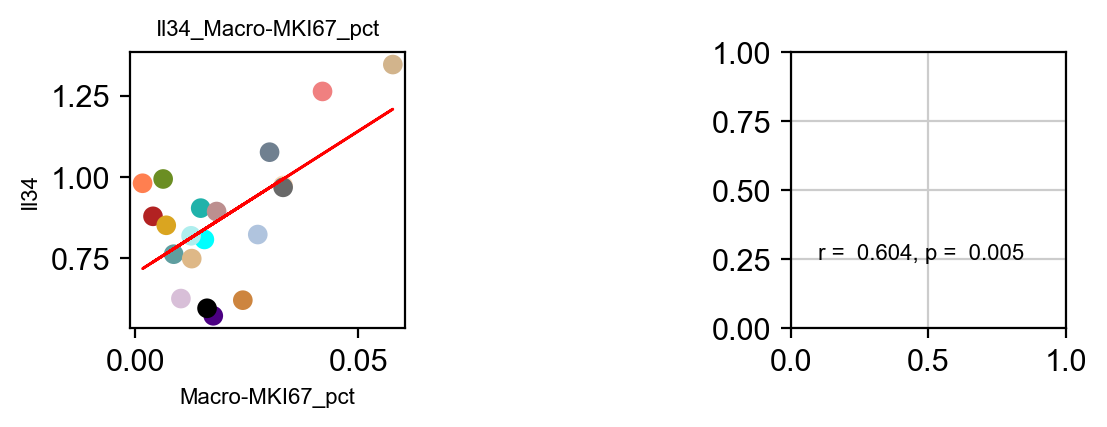

In [227]:
plt.figure(figsize = (6,6))  #set figure size
fig = plt.figure() 
ax1 = fig.add_subplot(231) 
ax1.set_title(z, fontdict={"size":8} ) 
 
r,p = stats.pearsonr(x, y) 

ax1.scatter(x, y, c=color,s=50,alpha=1, linewidths=0) # plot scatters

regr = linear_model.LinearRegression()
regr.fit(x.reshape(-1,1),y) 
a, b = regr.coef_, regr.intercept_
ax1.plot(x,  regr.predict(x.reshape(-1,1)), color='red', linewidth=1)


plt.xlabel(x_label, fontdict={"size":8})
plt.ylabel(y_label, fontdict={"size":8}) 

ax2 = fig.add_subplot(233)
ax2.text(0.1, 0.25, r'r = %6.3f, p = %6.3f'%(r,p), fontdict={"size":8})
#ax2.text(0.1, 0.5,r'a = %6.3f, b = %6.3f'%(a,b), fontdict={"size":8})
plt.grid()  # show grids


#make the file that we will store these plots in 
try:
    directoryName=project_ID+"_DEG"
    os.mkdir(directoryName)
except:
    pass

plt.savefig(f"{project_ID}_DEG/pearson_{z}_color2.pdf",dpi=300)
plt.show()  # show plots

In [ ]:
plt.figure(figsize = (6,6))  #set figure size
fig = plt.figure() 
ax1 = fig.add_subplot(231) 
ax1.set_title(z, fontdict={"size":8} ) 
 
r,p = stats.pearsonr(x, y) 

ax1.scatter(x, y, c=color,s=50,alpha=1, linewidths=0) # plot scatters

regr = linear_model.LinearRegression()
regr.fit(x.reshape(-1,1),y) 
a, b = regr.coef_, regr.intercept_
ax1.plot(x,  regr.predict(x.reshape(-1,1)), color='red', linewidth=1)


plt.xlabel(x_label, fontdict={"size":8})
plt.ylabel(y_label, fontdict={"size":8}) 

ax2 = fig.add_subplot(233)
ax2.text(0.1, 0.25, r'r = %6.3f, p = %6.3f'%(r,p), fontdict={"size":8})
#ax2.text(0.1, 0.5,r'a = %6.3f, b = %6.3f'%(a,b), fontdict={"size":8})
plt.grid()  # show grids


#make the file that we will store these plots in 
try:
    directoryName=project_ID+"_DEG"
    os.mkdir(directoryName)
except:
    pass

plt.savefig(f"{project_ID}_DEG/pearson_{z}_color2.pdf",dpi=300)
plt.show()  # show plots

## Export average expression matrix 
we can calculate an average expression of each gene in the way we group the cells

In [ ]:
def grouped_obs_mean(adata, group_key, layer=None, gene_symbols=None):
    if layer is not None:
        getX = lambda x: x.layers[layer]
    else:
        getX = lambda x: x.X
    if gene_symbols is not None:
        new_idx = adata.var[idx]
    else:
        new_idx = adata.var_names

    grouped = adata.obs.groupby(group_key)
    out = pd.DataFrame(
        np.zeros((adata.shape[1], len(grouped)), dtype=np.float64),
        columns=list(grouped.groups.keys()),
        index=adata.var_names
    )

    for group, idx in grouped.indices.items():
        X = getX(adata[idx])
        out[group] = np.ravel(X.mean(axis=0, dtype=np.float64))
    return out

In [ ]:
group_by="RSR_sample"
average_expression=grouped_obs_mean(adata_, group_by, layer="spliced", # when layer=None, it will return an average expression of scaled spliced RNA matrix, which is layer "X"
                                    gene_symbols=None)
min_np=np.array([])
max_np=np.array([])
for k in average_expression.index.values:
    min_np=np.append(min_np, average_expression.loc[k].min())
    max_np=np.append(max_np, average_expression.loc[k].max())
average_expression["min"]=min_np # we need to add "min" and "max" column for further scaling the average expression matrix
average_expression["max"]=max_np
for i in range(0,len(np.unique(adata_.obs[group_by]))): # scaling the expression matrix
    average_expression[f"{average_expression.iloc[:,i].name}_s"]=(average_expression.iloc[:,i]-average_expression["min"])/(average_expression["max"]-average_expression["min"])

In [ ]:
# export a sub matrix only containing DEG average expression of cluster0, cluster1 and cluster2
#I changed this from figures to the fig deg file

average_expression=average_expression.iloc[:,:len(np.unique(adata_mye.obs[group_by]))]
average_expression.index=map(lambda x:x.upper(),average_expression.index)
b=average_expression#.to_csv(f"./{project_ID}_DEG/Sample_ID_DEG_ms_avr.csv")

In [ ]:
# export a sub matrix only containing DEG average expression of cluster0, cluster1 and cluster2
#I changed this from figures to the fig deg file

average_expression=average_expression.loc[np.unique(deg)].iloc[:,0:len(np.unique(adata_.obs[group_by]))]
average_expression.index=map(lambda x:x.upper(),average_expression.index)
average_expression.to_csv(f"./{project_ID}_DEG/T127_G2M_RSR_avr.csv")

In [ ]:
# export a sub matrix only containing DEG average expression of cluster0, cluster1 and cluster2
#I changed this from figures to the fig deg file

average_expression=average_expression.iloc[:,:len(np.unique(adata.obs[group_by]))]
average_expression.index=map(lambda x:x.upper(),average_expression.index)
a=average_expression#.to_csv(f"./{project_ID}_DEG/Sample_ID_s_avr.csv")

In [ ]:
corr=pd.concat([a, b], axis=1).cov()
corr.iloc[:,:3].iloc[3:,:]

In [ ]:
corr=pd.concat([a, b], axis=1).corr("spearman", min_periods=120)
corr.iloc[:,:3].iloc[3:,:]

In [198]:
#adata_t=adata
adata=adata[(adata.obs.treatment.str.startswith("T127"))]

## Cell fraction bar charts

In [199]:
# we can plot feature percentage in the population we group cells, treatment or clusters
# first we need to call a cell_fraction matrix containing matched feature and group_by information of each single cell
feature="anno_clusters"
group_by="treatment"#treatment Group
cell_fraction=pd.DataFrame(adata.obs[group_by].values,columns=[group_by],index=adata.obs[feature])

In [200]:
fraction=pd.DataFrame([])
for i in np.unique(adata.obs[group_by]):
    adata_=adata[adata.obs[group_by]==i]
    fraction_=np.array([])
    for x in np.unique(adata.obs[feature]):
        frac=len(adata_[adata_.obs[feature]==x])
        fraction_=pd.Series(np.append(fraction_, frac))
    fraction=pd.concat([fraction, fraction_], axis=1)
fraction.columns=np.unique(adata.obs[group_by])
fraction.index=np.unique(adata.obs[feature])

In [201]:
# we calculate the percentage of each feature in each group
fraction.loc["sum"]=fraction.sum(axis=0)
for i in np.unique(adata.obs[feature]):
    fraction.loc[f"{i}_pct"]=fraction.loc[i]/fraction.loc["sum"]
fraction.to_csv(f"{project_ID}_figures/{feature}_fraction_{group_by}.csv")

In [202]:
# we drop the cell number rows and leave the percentage rows
fraction_=fraction.T
for i in np.unique(adata.obs[feature]):
    fraction_=fraction_.drop([i],axis=1)
fraction_=fraction_.drop(["sum"],axis=1)
fraction_

,B.cells_pct,CD14-IL1B_pct,CD14-PF4_pct,CD16-CDKN1C_pct,CD4_Tcm-TCF7_pct,CD4_Treg-FOXP3_pct,CD8_Tn-CCR7_pct,Endo.cells_pct,Macro-M1_pct,Macro-M2_pct,...,Malign_0_pct,Malign_1_pct,Malign_2_pct,Malign_3_pct,NK.cells_pct,Tgd_pct,Tprf-MKI67_pct,i_CAF_pct,my_CAF_pct,pDC_pct
T127_O4_1,0.006446,0.014733,0.004604,0.063536,0.019337,0.021179,0.008287,0.015654,0.000921,0.174033,...,0.284530,0.285451,0.000000,0.000000,0.014733,0.000000,0.000000,0.012891,0.001842,0.019337
T127_O4_2,0.002685,0.004027,0.005369,0.037584,0.020134,0.005369,0.000000,0.004027,0.000000,0.049664,...,0.303356,0.531544,0.000000,0.000000,0.014765,0.000000,0.000000,0.001342,0.000000,0.009396
T127_O4_3,0.003600,0.013501,0.003600,0.037804,0.042304,0.029703,0.000900,0.014401,0.000000,0.051305,...,0.376238,0.373537,0.000000,0.000000,0.013501,0.002700,0.000000,0.003600,0.000000,0.014401
T127_O8_1,0.005725,0.033397,0.012405,0.057252,0.023855,0.008588,0.001908,0.013359,0.000000,0.234733,...,0.296756,0.167939,0.000000,0.000000,0.012405,0.003817,0.000000,0.015267,0.004771,0.023855
T127_O8_2,0.006217,0.034636,0.012433,0.055062,0.021314,0.010657,0.001776,0.019538,0.000000,0.235346,...,0.265542,0.176732,0.000000,0.000000,0.023091,0.004440,0.000000,0.009769,0.000000,0.021314
T127_O8_3,0.003887,0.020408,0.016521,0.052478,0.018465,0.013605,0.000972,0.020408,0.000000,0.233236,...,0.319728,0.176871,0.000000,0.000000,0.022352,0.001944,0.000000,0.015549,0.000972,0.013605
T127_V_1,0.006768,0.006768,0.005076,0.030457,0.027073,0.031303,0.002538,0.015228,0.000846,0.062606,...,0.385787,0.366328,0.000000,0.000000,0.016074,0.001692,0.000000,0.014382,0.000000,0.010998
T127_V_2,0.005882,0.010294,0.004412,0.075000,0.030882,0.025000,0.000000,0.010294,0.001471,0.097059,...,0.245588,0.370588,0.000000,0.000000,0.026471,0.001471,0.001471,0.023529,0.000000,0.023529
T127coo1,0.000000,0.008628,0.002588,0.205349,0.014668,0.006040,0.000000,0.012079,0.000000,0.076790,...,0.238999,0.274374,0.003451,0.000863,0.008628,0.006903,0.000000,0.051769,0.006040,0.012942
T127coo2,0.000000,0.015168,0.004334,0.173348,0.017335,0.007584,0.000000,0.010834,0.003250,0.089924,...,0.301192,0.274106,0.002167,0.003250,0.011918,0.001083,0.003250,0.026002,0.002167,0.006501


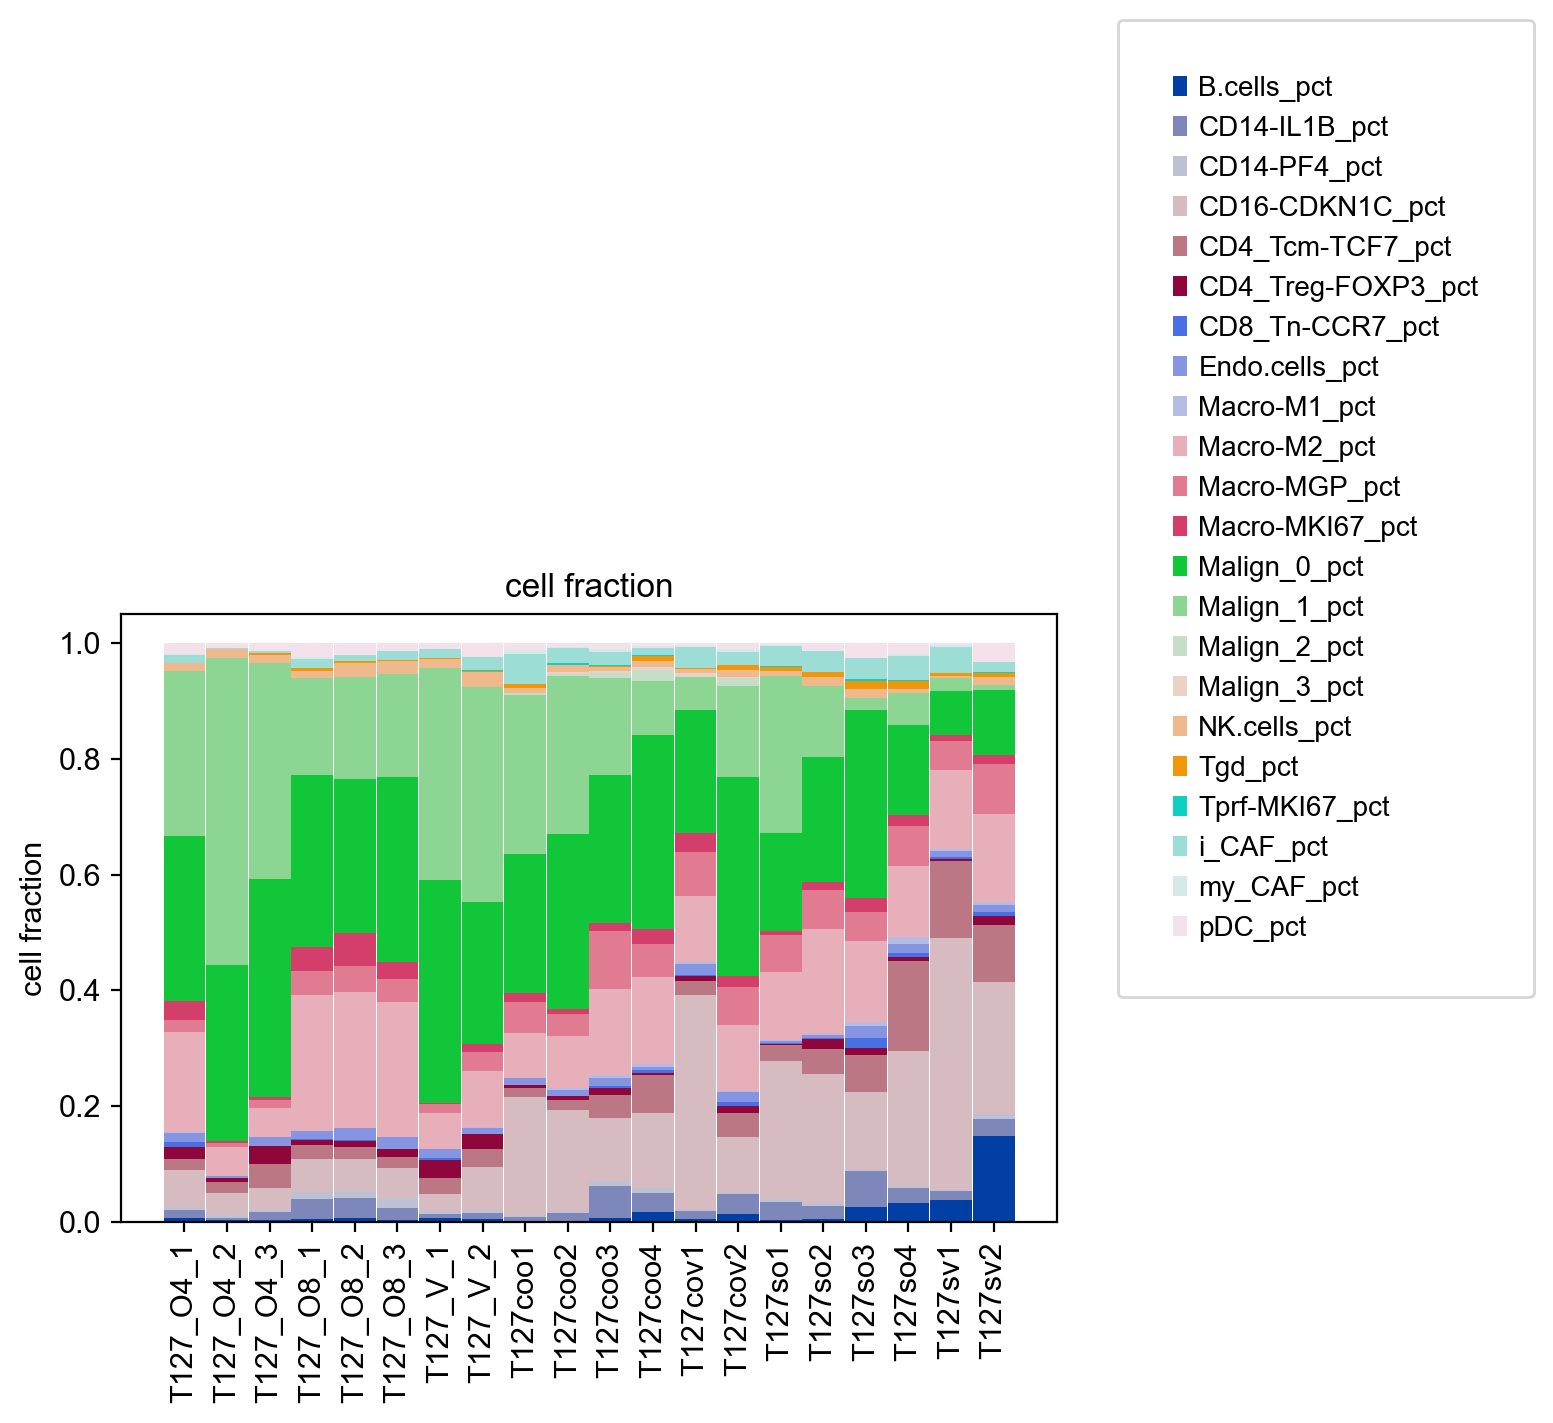

In [127]:
df_=fraction_
#plot the cell percentage bar chart
labels =np.unique(adata.obs[group_by])

width = 0.98    # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots()
x = np.arange(0, len(labels))
bottom=0
for i in range (0, len(df_.columns)): 
    ax.bar(x,  df_.iloc[:,i], width, yerr=None, label=df_.columns[i][:1], bottom=bottom, color=scv.utils.interpret_colorkey(adata[adata.obs[feature]==df_.iloc[:,i].name[:-4]],c=f"{feature}"))
    bottom=bottom+df_.iloc[:,i].values
    

plt.xticks(x, labels,rotation=90)
ax.set_ylabel('cell fraction')
ax.set_title('cell fraction')
legend=ax.legend(df_.columns,bbox_to_anchor=(1.05, 1,3,1), loc='upper left', prop={'size':10},borderpad=2)

fig.show()
fig.savefig(f"{project_ID}_figures/{feature}_fraction_{group_by}.pdf",bbox_extra_artists=(legend,),bbox_inches="tight",dpi=300)

## Export meta

In [ ]:
#load the processed h5ad 
#To run this chunk you must first process the data and run the trajectory section

adata = sc.read(f'.\\{project_ID}_figures\\{project_ID}_pp.h5ad', gex_only=True)
Cell_ID=adata.to_df().index

In [ ]:
treat_brf=pd.Series("ola", index=adata.obs_names)
treat_brf[adata.obs.treatment.str.startswith("T127_V")]="veh"
treat_brf[adata.obs.treatment.str.startswith("T22_V")]="veh"
adata.obs["treatment_brf"]=treat_brf.values

In [ ]:
treat_brf=pd.Series("ola", index=adata.obs_names)
treat_brf[adata.obs.treatment.str.startswith("T127sv")]="veh"
treat_brf[adata.obs.treatment.str.startswith("T22sv")]="veh"
treat_brf[adata.obs.treatment.str.startswith("T127cov")]="veh"
treat_brf[adata.obs.treatment.str.startswith("T22cov")]="veh"
adata.obs["treatment_brf"]=treat_brf.values

In [ ]:
#export the full matrix of spliced RNA
adata_=adata[((adata.obs_names.str.startswith("coGEX8")))]
#export meta data for R packages
meta_sample_clusters=pd.DataFrame(adata_.obs.anno_clusters)

meta_sample_clusters.to_csv(f"{project_ID}_DEG/meta_co_gex8.csv")

In [ ]:
#export the full matrix of spliced RNA
adata_=adata[((adata.obs_names.str.startswith("T1"))&(adata.obs.treatment.str.startswith("T127_")))]
raw_=pd.DataFrame(data=adata_.raw.X.toarray(), index=adata_.obs_names, columns=adata_.raw.var_names)
matrix=raw_
#matrix.index=map(lambda x:x.upper(),matrix.index)
matrix.to_csv(f"./{project_ID}_DEG/matrix_T127_gex1_raw.csv",header=True)

In [ ]:
np.unique(adata.obs.anno_clusters)

In [ ]:
'B.cells', 'CD14.IL1B', 'CD14.PF4', 'CD16.CDKN1C', 'CD4_Tcm.TCF7',
       'CD4_Treg.FOXP3', 'CD8_Tn.CCR7', 'Endo.cells', 'Macro.M1',
       'Macro.M2', 'Macro.MGP', 'Macro.MKI67', 'Malign_0', 'Malign_1',
       'Malign_2', 'Malign_3', 'NK.cells', 'Tgd', 'Tprf.MKI67', 'i_CAF',
       'my_CAF', 'pDC'

In [ ]:
B.cells = "#8b008b ",CD14.IL1B = "#00ff7f" ,CD14.PF4 = "#20b2aa" ,CD16.CDKN1C = "#6b8e23" ,
CD4_Tcm.TCF7 = "#da70d6" ,CD4_Treg.FOXP3 ="#f08080" ,CD8_Tn.CCR7 = "#b22222" ,Endo.cells = "#d2b48c" ,
Macro.M1 = "#00ffff" ,Macro.M2 = "#5f9ea0 ",Macro.MGP = "#4169e1" ,Macro.MKI67 = "#191970" ,
Malign_0 = "#b0c4de" ,Malign_1 = "#696969" ,Malign_2 = "#708090" ,Malign_3 = "#000000" ,
NK.cells = "#cd853f" ,Tgd = "#dc143c" ,Tprf.MKI67 = "#ff7f50" ,i_CAF = "#bc8f8f" ,my_CAF = "#daa520" ,
pDC = "#00bfff "

In [ ]:
Malign_0='#da70d6', Malign_1='#da70d6', Malign_2='#f08080', Malign_3='#f08080', 
T127coo_B.cells='#808080',T127coo_CD14.IL1B='#dc143c' , T127coo_CD14.PF4='#dc143c', T127coo_CD16.CDKN1C='#dc143c',T127coo_Endo_Fibro='#808080',
T127coo_Macro.M1='#ff7f50', T127coo_Macro.M2='#ff7f50',T127coo_Macro.MGP='#ff7f50', T127coo_Macro.MKI67='#ff7f50', T127coo_T_cells='#808080',
T127coo_pDC='#808080', 

T127cov_B.cells='#808080',T127cov_CD14.IL1B='#dc143c' , T127cov_CD14.PF4='#dc143c',T127cov_CD16.CDKN1C='#cd853f', T127cov_Endo_Fibro='#808080', 
T127cov_Macro.M2='#8b008b', T127cov_Macro.MGP='#8b008b', T127cov_Macro.MKI67='#8b008b',T127cov_T_cells='#808080',T127cov_pDC='#808080',

T127so_B.cells='#808080',T127so_CD14.IL1B='#b22222' , T127so_CD14.PF4='#b22222' , T127so_CD16.CDKN1C='#b22222' , T127so_Endo_Fibro='#808080',
T127so_Macro.M1='#00bfff', T127so_Macro.M2='#00bfff',T127so_Macro.MGP='#00bfff', T127so_Macro.MKI67='#00bfff', T127so_T_cells='#808080',
T127so_pDC='#808080', 

T127sv_B.cells='#808080', T127sv_CD14.IL1B='#00ff7f' ,T127sv_CD14.PF4='#00ff7f' , T127sv_CD16.CDKN1C='#00ff7f' , T127sv_Endo_Fibro='#808080',
T127sv_Macro.M1='#20b2aa',T127sv_Macro.M2='#20b2aa', T127sv_Macro.MGP='#20b2aa', T127sv_Macro.MKI67='#20b2aa',T127sv_T_cells='#808080',
T127sv_pDC='#808080',

T22coo_B.cells='#808080',T22coo_CD14.IL1B='#6b8e23', T22coo_CD14.PF4='#6b8e23', T22coo_CD16.CDKN1C='#6b8e23',T22coo_Endo_Fibro='#808080', 
T22coo_Macro.M1='#00ffff', T22coo_Macro.M2='#00ffff',T22coo_Macro.MGP='#00ffff', T22coo_Macro.MKI67='#00ffff', T22coo_T_cells='#808080',
T22coo_pDC='#808080', 

T22cov_B.cells='#808080', T22cov_CD14.IL1B='#5f9ea0' ,T22cov_CD16.CDKN1C='#5f9ea0' , T22cov_Endo_Fibro='#808080',
T22cov_Macro.M1='#4169e1', T22cov_Macro.M2='#4169e1', T22cov_Macro.MGP='#4169e1', T22cov_Macro.MKI67='#4169e1', T22cov_T_cells='#808080', 
#T22cov_pDC='#808080',
       
T22so_B.cells='#808080', T22so_CD14.IL1B='#b0c4de' , T22so_CD14.PF4='#b0c4de' , T22so_CD16.CDKN1C='#b0c4de' , T22so_Endo_Fibro='#808080', 
T22so_Macro.M1='#696969',T22so_Macro.M2='#696969', T22so_Macro.MGP='#696969', T22so_Macro.MKI67='#696969',T22so_T_cells='#808080',
T22so_pDC='#808080',

T22sv_B.cells='#808080', T22sv_CD14.IL1B='#708090',  T22sv_CD16.CDKN1C='#708090', T22sv_Endo_Fibro='#808080',
T22sv_Macro.M1='#bc8f8f', T22sv_Macro.M2='#bc8f8f', T22sv_Macro.MGP='#bc8f8f', T22sv_Macro.MKI67='#bc8f8f', T22sv_T_cells='#808080',
T22sv_pDC='#808080'

In [ ]:
adata_=adata[adata.obs_names.str.startswith("coGEX6")]

In [ ]:
#export the full matrix of spliced RNA
matrix=adata_.copy().T.to_df()
#matrix.index=map(lambda x:x.upper(),matrix.index)
matrix.to_csv(f"./{project_ID}_DEG/coGEX6_matrix_raw.csv",header=True)

In [ ]:
#export meta data for R packages
meta_sample_clusters=pd.concat([adata_.obs.treatment,adata_.obs.anno_clusters],axis=1)
meta_sample_clusters["cell.names"]=meta_sample_clusters.index.str.replace(f":",".",regex=True)
meta_sample_clusters["cell.names"]=meta_sample_clusters["cell.names"].str.replace("-",".",regex=True)
meta_sample_clusters["anno_clusters"]=meta_sample_clusters["anno_clusters"].str.replace("-",".",regex=True)
meta_sample_clusters.index=meta_sample_clusters["cell.names"]
meta_sample_clusters.iloc[:,:2].to_csv(f"{project_ID}_DEG/coGEX6_meta_anno_clusters.csv")

In [ ]:
#export meta data for R packages
meta_sample_clusters=pd.concat([adata.obs.clusters],axis=1)
for i in range (0,len(np.unique(adata.obs.clusters))):
    meta_sample_clusters=meta_sample_clusters.replace(f"{i}",f"cluster{i}") 
meta_sample_clusters["cell.cnames"]=meta_sample_clusters.index.str.replace(f"pre:","pre.",regex=True)
meta_sample_clusters["cell.names"]=meta_sample_clusters["cell.names"].str.replace("x-","x_",regex=True)
meta_sample_clusters.to_csv(f"{project_ID}_DEG/meta_clusters.csv")

In [ ]:
#print cluster color list in order to make R output and python output cluster colors identical
print(adata_bk.uns["anno_clusters_colors"])
#print(adata.uns["Sample_ID_colors"])

## Save h5ad

In [ ]:
sub_pop_name="CD14_CD16_Macro"
#sub_pop=[cells for cells in adata.obs_names if adata[cells].obs.anno_clusters[0].startswith(f"{sub_pop_name}")]

In [ ]:
sub_pop_1=[cells for cells in adata.obs_names if adata[cells].obs.anno_clusters2[0].startswith("Macro")]
sub_pop_2=[cells for cells in adata.obs_names if adata[cells].obs.anno_clusters2[0].startswith("CD16")]
sub_pop_3=[cells for cells in adata.obs_names if adata[cells].obs.anno_clusters2[0].startswith("CD14")]
#sub_pop_4=[cells for cells in adata.obs_names if adata[cells].obs.anno_clusters2[0].startswith("CD8")]

In [ ]:
sub_pop_1=adata[adata.obs.anno_clusters.str.startswith("Macro")].obs_names
sub_pop_2=adata[adata.obs.anno_clusters.str.startswith("CD14")].obs_names
sub_pop_3=adata[adata.obs.anno_clusters.str.startswith("CD16")].obs_names

In [ ]:
sub_pop=np.append(np.append(sub_pop_1,sub_pop_2),sub_pop_3)#+sub_pop_4

In [ ]:
len(sub_pop)

In [ ]:
#plot umap grouped by treatment
scv.pl.scatter(adata[sub_pop],save=f"{sub_pop_name}_cells_umap.pdf", 
               basis="umap",legend_loc="right",color="anno_clusters",
            size=10, alpha=0.8,
            )

In [ ]:
#adata_=sc.read(f"pool_reconcat_nice.h5ad", gex_only=True)
#adata_.var_names_make_unique("_")
#filter out outliers
adata_ = adata[sub_pop,:]
#adata_.obs["anno_clusters"]=adata[sub_pop,:].obs["anno_clusters"].values
adata_.write(f"pool_CD14_CD16_Macro_cells_anno_raw_nice.h5ad")

In [ ]:
adata=sc.read(f"pool_reconcat2_5_6.h5ad", gex_only=True)
adata.var_names_make_unique("_")
#adata_raw=adata_raw[adata.obs_names,:]
#adata_raw.obs["anno_clusters"]=adata.obs.anno_clusters

In [ ]:
adata.obs["Sample_ID"]=adata.obs.treatment

In [ ]:
treatment=pd.Series("Unknown", index=adata.obs_names)
treatment[adata.obs.treatment.str.startswith("T22_V")]="T22_V"
treatment[adata.obs.treatment.str.startswith("T22_O4")]="T22_ola_4d"
treatment[adata.obs.treatment.str.startswith("T127_V")]="T127_V"
treatment[adata.obs.treatment.str.startswith("T127_O4")]="T127_ola_4d"
treatment[adata.obs.treatment.str.startswith("T22_O8")]="T22_ola_8d"
treatment[adata.obs.treatment.str.startswith("T127_O8")]="T127_ola_8d"
treatment[adata.obs.treatment.str.startswith("T22sv")]="T22sv"
treatment[adata.obs.treatment.str.startswith("T22so")]="T22so"
treatment[adata.obs.treatment.str.startswith("T22cov")]="T22cov"
treatment[adata.obs.treatment.str.startswith("T22coo")]="T22coo"
treatment[adata.obs.treatment.str.startswith("T127sv")]="T127sv"
treatment[adata.obs.treatment.str.startswith("T127so")]="T127so"
treatment[adata.obs.treatment.str.startswith("T127cov")]="T127cov"
treatment[adata.obs.treatment.str.startswith("T127coo")]="T127coo"
adata.obs["treatment"]=treatment.values

In [ ]:
treatment=pd.Series("Unknown", index=adata.obs_names)
treatment[adata.obs.Sample_ID.str.startswith("T22_V")]="T22_V"
treatment[adata.obs.Sample_ID.str.startswith("T22_O4")]="T22_ola"
treatment[adata.obs.treatment.str.startswith("T127_V")]="T127_V"
treatment[adata.obs.treatment.str.startswith("T127_O4")]="T127_ola"
treatment[adata.obs.Sample_ID.str.startswith("T22_O8")]="T22_ola"
treatment[adata.obs.treatment.str.startswith("T127_O8")]="T127_ola"
treatment[adata.obs.treatment.str.startswith("T22sv")]="T22sv"
treatment[adata.obs.treatment.str.startswith("T22so")]="T22so"
treatment[adata.obs.treatment.str.startswith("T22cov")]="T22cov"
treatment[adata.obs.treatment.str.startswith("T22coo")]="T22coo"
treatment[adata.obs.treatment.str.startswith("T127sv")]="T127sv"
treatment[adata.obs.treatment.str.startswith("T127so")]="T127so"
treatment[adata.obs.treatment.str.startswith("T127cov")]="T127cov"
treatment[adata.obs.treatment.str.startswith("T127coo")]="T127coo"
adata.obs["treatment2"]=treatment.values

In [ ]:
adata.obs["RSR_sample"]=adata.obs["RSR_clusters"].astype(str)+"_"+adata.obs["treatment"].astype(str)
adata.obs["RSR_sample"]=adata.obs["RSR_sample"].astype("category")

In [ ]:
treatment=pd.Series("Unknown", index=adata.obs_names)
treatment[adata.obs.treatment.str.startswith("T22sv")]="T22sv"
treatment[adata.obs.treatment.str.startswith("T22so")]="T22so"
treatment[adata.obs.treatment.str.startswith("T22cov")]="T22cov"
treatment[adata.obs.treatment.str.startswith("T22coo")]="T22coo"
treatment[adata.obs.treatment.str.startswith("T127sv")]="T127sv"
treatment[adata.obs.treatment.str.startswith("T127so")]="T127so"
treatment[adata.obs.treatment.str.startswith("T127cov")]="T127cov"
treatment[adata.obs.treatment.str.startswith("T127coo")]="T127coo"
adata.obs["treatment"]=treatment.values

In [ ]:
strain=pd.Series("Unknown", index=adata.obs_names)
strain[adata.obs.treatment.str.startswith("T22")]="T22"
strain[adata.obs.treatment.str.startswith("T127")]="T127"
adata.obs["strain"]=adata.obs.treatment

In [ ]:
Sample_anno=pd.Series("Unknown", index=adata.obs_names)
Sample_anno[adata.obs.cell_type.str.endswith("malign")]=adata[adata.obs.cell_type.str.endswith("malign")].obs.anno_clusters.astype(str)
Sample_anno[adata.obs.cell_type=="Endo_Fibro"]=adata[adata.obs.cell_type=="Endo_Fibro"].obs.strain.astype(str)+"_"+adata[adata.obs.cell_type=="Endo_Fibro"].obs.cell_type.astype(str)
Sample_anno[adata.obs.cell_type=="Macro_Mono"]=adata[adata.obs.cell_type=="Macro_Mono"].obs.strain.astype(str)+"_"+adata[adata.obs.cell_type=="Macro_Mono"].obs.anno_clusters.astype(str)
Sample_anno[adata.obs.cell_type=="T_cells"]=adata[adata.obs.cell_type=="T_cells"].obs.strain.astype(str)+"_"+adata[adata.obs.cell_type=="T_cells"].obs.cell_type.astype(str)
Sample_anno[adata.obs.cell_type=="B.cells"]=adata[adata.obs.cell_type=="B.cells"].obs.strain.astype(str)+"_"+adata[adata.obs.cell_type=="B.cells"].obs.cell_type.astype(str)
Sample_anno[adata.obs.cell_type=="pDC"]=adata[adata.obs.cell_type=="pDC"].obs.strain.astype(str)+"_"+adata[adata.obs.cell_type=="pDC"].obs.cell_type.astype(str)
adata.obs["Sample_type"]=Sample_anno.values

In [ ]:
term=pd.Series("long", index=adata.obs_names)
term[adata.obs.treatment.str.startswith("T22_")]="short"
term[adata.obs.treatment.str.startswith("T127_")]="short"
adata.obs["term"]=term.values

In [ ]:
treatment=pd.Series("Unknown", index=adata.obs_names)
treatment[adata.obs.Sample_ID!="T22cov1"]=adata[adata.obs.Sample_ID!="T22cov1"].obs.treatment
treatment[adata.obs.Sample_ID.str.endswith("cov1")]="cov"
treatment[adata.obs.Sample_ID.str.endswith("cov2")]="cov"
treatment[adata.obs.Sample_ID.str.endswith("coo1")]="coo"
treatment[adata.obs.Sample_ID.str.endswith("coo2")]="coo"
treatment[adata.obs.Sample_ID.str.endswith("coo3")]="coo"
treatment[adata.obs.Sample_ID.str.endswith("coo4")]="coo"
adata.obs["treatment2"]=treatment.values

In [ ]:
anno_merge=pd.Series("malign",index=adata.obs_names)
anno_merge[adata.obs.cell_type!="long_malign"]=adata[adata.obs.cell_type!="long_malign"].obs.anno_clusters
adata.obs["anno_merg"]=anno_merge.values

In [ ]:
#export the full matrix of spliced RNA
for treatment in ['T22so1', 'T22so2', 'T22so3', 'T22so4', 'T22sv1',
       'T22sv2', 'T127so1', 'T127so2', 'T127so3', 'T127so4', 'T127sv1',
       'T127sv2', "cov1","cov2","coo1","coo2","coo3","coo4"]: 
    sub_pop_name=treatment
    adata_=adata[adata[adata.obs.treatment.str.endswith(sub_pop_name)].obs_names,:]
    matrix=adata_.copy().T.to_df(layer="spliced")
    matrix.to_csv(f"./{project_ID}_DEG/matrix_{sub_pop_name}_s.csv",header=True)
    meta_sample_clusters=pd.concat([adata_.obs.Sample_anno],axis=1)
    meta_sample_clusters["cell.names"]=meta_sample_clusters.index.str.replace(f":",".",regex=True)
    meta_sample_clusters["cell.names"]=meta_sample_clusters["cell.names"].str.replace("-",".",regex=True)
    meta_sample_clusters.index=meta_sample_clusters["cell.names"]
    meta_sample_clusters=meta_sample_clusters.iloc[:,:1]
    meta_sample_clusters.to_csv(f"{project_ID}_DEG/meta_{sub_pop_name}_long_clusters.csv")

In [ ]:
matrix=adata[adata.obs.term=="short"].copy().T.to_df(layer="spliced")
matrix.to_csv(f"./{project_ID}_DEG/matrix_everything_short_s.csv",header=True)

In [ ]:
meta_sample_clusters=pd.concat([adata[adata.obs.term=="long"].obs.Sample_anno],axis=1)
meta_sample_clusters["cell.names"]=meta_sample_clusters.index.str.replace(f":",".",regex=True)
meta_sample_clusters["cell.names"]=meta_sample_clusters["cell.names"].str.replace("-",".",regex=True)
meta_sample_clusters.index=meta_sample_clusters["cell.names"]
meta_sample_clusters=meta_sample_clusters.iloc[:,:1]
meta_sample_clusters.to_csv(f"{project_ID}_DEG/meta_everything_co_Sample_anno.csv")

In [ ]:
meta_sample_clusters=pd.concat([adata[adata.obs.term=="long"].obs.treatment2],axis=1)
meta_sample_clusters["cell.names"]=meta_sample_clusters.index.str.replace(f":",".",regex=True)
meta_sample_clusters["cell.names"]=meta_sample_clusters["cell.names"].str.replace("-",".",regex=True)
meta_sample_clusters.index=meta_sample_clusters["cell.names"]
meta_sample_clusters=meta_sample_clusters.iloc[:,:1]
meta_sample_clusters.to_csv(f"{project_ID}_DEG/meta_everything_long_treatment.csv")

In [ ]:
meta_sample_clusters=pd.concat([adata[adata.obs.term=="long"].obs.anno_clusters],axis=1)
meta_sample_clusters["cell.names"]=meta_sample_clusters.index.str.replace(f":",".",regex=True)
meta_sample_clusters["cell.names"]=meta_sample_clusters["cell.names"].str.replace("-",".",regex=True)
meta_sample_clusters.index=meta_sample_clusters["cell.names"]
meta_sample_clusters=meta_sample_clusters.iloc[:,:1]
meta_sample_clusters.to_csv(f"{project_ID}_DEG/meta_everything_long_anno_clusters.csv")

In [ ]:
score_name="MM_GO_antigen_presentation_score"
score_exp=pd.DataFrame(adata.obs[score_name].values,columns=[score_name],index=adata.obs['Sample_anno'])
#score_exp= score_exp.groupby(level=0)
score_exp.to_csv(f"{project_ID}_DEG/{project_ID}_{score_name}.csv")

In [ ]:
#export the full matrix of spliced RNA
for treatment in np.unique(adata[adata.obs.treatment.str.startswith("T22_")].obs.treatment): 
    sub_pop_name=treatment
    adata_=adata[adata.obs.treatment.str.endswith(sub_pop_name),:]
    #scv.pp.filter_and_normalize(adata_, min_cells=0.01%(len(adata.to_df())), flavor="seurat")
    matrix=adata_.copy().T.to_df(layer="spliced")
    matrix.to_csv(f"./{project_ID}_DEG/matrix_{sub_pop_name}_s.csv",header=True)
    meta_sample_clusters=pd.concat([adata_.obs.anno_clusters],axis=1)
    meta_sample_clusters["cell.names"]=meta_sample_clusters.index.str.replace(f":",".",regex=True)
    meta_sample_clusters["cell.names"]=meta_sample_clusters["cell.names"].str.replace("-","_",regex=True)
    meta_sample_clusters.index=meta_sample_clusters["cell.names"]
    meta_sample_clusters=meta_sample_clusters.iloc[:,:1]
    meta_sample_clusters.to_csv(f"{project_ID}_DEG/meta_{sub_pop_name}_clusters.csv")

In [ ]:

markers ={
    "Myeloid.cells":["Itgam","Fcgr3"],
    "MDSCs":["Ly6g","Ly6c1","Ly6c2","Lin28a","Cd33","Fut4","C5ar1"],
    "Granulocytes":["Csf3r","Cd63"],
    "Dendritic.cells":["Itgax","Clec9a","Clec10a","Siglech","Bst2","Cd300c","Lsp1","Ly75","Cd209a","Cd1d1"],
    "Monocytes":["Cd14","Cd300a","F13a1","Hp","Vcan"],
    "Macrophages":["Lyz2","Cd68","Csf1r","Adgre1","C1qa","C1qb","C1qc"],
    "TREM":["Trem1","Trem2"],
    "M1_TAM":["Cd86","Cx3cr1","Cxcl16",],
    "M2_TAM":["Mrc1","Siglec1"],
    "Microglia":["Tmem119","P2ry12"],
    "Immune_checkpoint":["Cd274","Cd80"],
    "CLCF1-CNTFR":["Clcf1","Lif","Cntf","Cntfr","Lifr","Il6st"],
    "MHC-II":['H2-K1','H2-Aa','H2-T23','H2-M5', 'H2-M2','H2-Oa','H2-DMb2','H2-Ob' ,'H2-Ab1', 'H2-Eb2', 'H2-D1','H2-Q7',]
}

sc.pl.dotplot(adata[adata.obs.treatment.str.startswith("T22_")], markers,standard_scale="var",cmap="RdYlBu_r",
                     mean_only_expressed=False, expression_cutoff=0,
                     groupby='anno_clusters2', dendrogram=True,save=f"{project_ID}_clusters.pdf")

In [ ]:
adata_=sc.read("pool_reconcat2_5_5.h5ad")

In [ ]:
adata=sc.read("pool_M1_M2_MKI67_figures/pool_M1_M2_MKI67_anno.h5ad")

In [ ]:
anno=pd.Series("Unknown", index=adata_.obs_names)
anno[adata_.obs.anno_clusters!="2"]=adata_.obs.anno_clusters
anno.loc[adata.obs_names]=adata.obs.anno_clusters2

In [ ]:
adata_.obs["anno_clusters"]=anno.values

In [ ]:
adata.obs["anno_clusters"]=adata.obs["anno_clusters2"]

In [ ]:
adata.write(f"{project_ID}_figures/{project_ID}_anno.h5ad")

In [ ]:
adata.write("pool_reconcat2_5_7.h5ad")

In [ ]:
np.unique(adata.obs.treatment)

In [ ]:
adata_s=adata[(adata.obs.RSR_group=="RSR")&(adata.obs.treatment.str.startswith("T127"))]

In [ ]:
raw=pd.DataFrame(data=adata_s.raw.X.toarray(), index=adata_s.obs_names, columns=adata_s.raw.var_names)

In [ ]:
adata.obs.RSR_sample

In [ ]:
group="RSR_sample"

In [ ]:
score_list=["MM_IFNG_score","chemotaxis score","HALLMARK_G2M_CHECKPOINT","HALLMARK_MITOTIC_SPINDLE",
            "HALLMARK_E2F_TARGETS",'HALLMARK_DNA_REPAIR','Hallmark_Tnfa_score',]
gene_list=["Cx3cl1","Ccnd1","Pold4","Rps12","Rps19","Csf1","Il34"]

In [ ]:
import math

In [ ]:
corr_list=np.array([])
for i in score_list:
    for k in score_list:
        x_label=i
        score_x = pd.DataFrame(adata_s.obs[x_label].values,columns=["score"],index=adata_s.obs[group])
        score_x = score_x.groupby(level=0).mean()
        
        y_label=k
        score_y = pd.DataFrame(adata_s.obs[y_label].values,columns=["score"],index=adata_s.obs[group])
        score_y = score_y.groupby(level=0).mean()
        
        x=score_x["score"].values
        y=score_y["score"]
        r,p = stats.pearsonr(x, y) 
        
        corr_list=np.append(corr_list,r)
index=np.array([])
for i in score_list:
    for k in score_list:
        index=np.append(index, i+"-"+k)
corr=pd.Series(corr_list, index=index)

In [ ]:
corr_list=np.array([])
for i in score_list:
    for k in gene_list:
        x_label=i
        score_x = pd.DataFrame(adata_s.obs[x_label].values,columns=["score"],index=adata_s.obs[group])
        score_x = score_x.groupby(level=0).mean()
        
        y_label=k
        gene_y = raw.loc[:,[y_label]]
        gene_y.index=adata_s.obs[group]
        gene_y =gene_y.groupby(level=0).mean()
        
        x=score_x["score"].values
        y=gene_y.loc[:,y_label].values
        r,p = stats.pearsonr(x, y) 
        
        corr_list=np.append(corr_list,r)
index=np.array([])
for i in score_list:
    for k in gene_list:
        index=np.append(index, i+"-"+k)
corr2=pd.Series(corr_list, index=index)

In [ ]:
corr_list=np.array([])
for i in gene_list:
    for k in gene_list:
        x_label=i
        gene_x = raw.loc[:,[x_label]]
        gene_x.index=adata_s.obs[group]
        gene_x =gene_x.groupby(level=0).mean()
        
        y_label=k
        gene_y = raw.loc[:,[y_label]]
        gene_y.index=adata_s.obs[group]
        gene_y =gene_y.groupby(level=0).mean()
        
        x=gene_x.loc[:,x_label].values
        y=gene_y.loc[:,y_label].values
        r,p = stats.pearsonr(x, y) 
        
        corr_list=np.append(corr_list,r)
index=np.array([])
for i in gene_list:
    for k in gene_list:
        index=np.append(index, i+"-"+k)
corr3=pd.Series(corr_list, index=index)

In [ ]:
corr_list=np.array([])
for i in gene_list:
    for k in score_list:
        x_label=i
        gene_x = raw.loc[:,[x_label]]
        gene_x.index=adata_s.obs[group]
        gene_x =gene_x.groupby(level=0).mean()
        
        y_label=k
        score_y = pd.DataFrame(adata_s.obs[y_label].values,columns=["score"],index=adata_s.obs[group])
        score_y = score_y.groupby(level=0).mean()
        
        x=gene_x.loc[:,x_label].values
        y=score_y["score"]
        r,p = stats.pearsonr(x, y) 
        
        corr_list=np.append(corr_list,r)
index=np.array([])
for i in gene_list:
    for k in score_list:
        index=np.append(index, i+"-"+k)
corr4=pd.Series(corr_list, index=index)

In [ ]:
corr_list=np.array([])
for i in score_list:
    for k in score_list:
        x_label=i
        score_x = pd.DataFrame(adata_s.obs[x_label].values,columns=["score"],index=adata_s.obs[group])
        score_x = score_x.groupby(level=0).mean()
        
        y_label=k
        score_y = pd.DataFrame(adata_s.obs[y_label].values,columns=["score"],index=adata_s.obs[group])
        score_y = score_y.groupby(level=0).mean()
        
        x=score_x["score"].values
        y=score_y["score"]
        r,p = stats.pearsonr(x, y) 
        
        corr_list=np.append(corr_list,math.log10(p+math.exp(-7)))
index=np.array([])
for i in score_list:
    for k in score_list:
        index=np.append(index, i+"-"+k)
pvalues=pd.Series(corr_list, index=index)

In [ ]:
corr_list=np.array([])
for i in score_list:
    for k in gene_list:
        x_label=i
        score_x = pd.DataFrame(adata_s.obs[x_label].values,columns=["score"],index=adata_s.obs[group])
        score_x = score_x.groupby(level=0).mean()
        
        y_label=k
        gene_y = raw.loc[:,[y_label]]
        gene_y.index=adata_s.obs[group]
        gene_y =gene_y.groupby(level=0).mean()
        
        x=score_x["score"].values
        y=gene_y.loc[:,y_label].values
        r,p = stats.pearsonr(x, y) 
        
        corr_list=np.append(corr_list,math.log10(p+math.exp(-7)))
index=np.array([])
for i in score_list:
    for k in gene_list:
        index=np.append(index, i+"-"+k)
pvalues2=pd.Series(corr_list, index=index)

In [ ]:
corr_list=np.array([])
for i in gene_list:
    for k in gene_list:
        x_label=i
        gene_x = raw.loc[:,[x_label]]
        gene_x.index=adata_s.obs[group]
        gene_x =gene_x.groupby(level=0).mean()
        
        y_label=k
        gene_y = raw.loc[:,[y_label]]
        gene_y.index=adata_s.obs[group]
        gene_y =gene_y.groupby(level=0).mean()
        
        x=gene_x.loc[:,x_label].values
        y=gene_y.loc[:,y_label].values
        r,p = stats.pearsonr(x, y) 
        
        corr_list=np.append(corr_list,math.log10(p+math.exp(-7)))
index=np.array([])
for i in gene_list:
    for k in gene_list:
        index=np.append(index, i+"-"+k)
pvalues3=pd.Series(corr_list, index=index)

In [ ]:
corr_list=np.array([])
for i in gene_list:
    for k in score_list:
        x_label=i
        gene_x = raw.loc[:,[x_label]]
        gene_x.index=adata_s.obs[group]
        gene_x =gene_x.groupby(level=0).mean()
        
        y_label=k
        score_y = pd.DataFrame(adata_s.obs[y_label].values,columns=["score"],index=adata_s.obs[group])
        score_y = score_y.groupby(level=0).mean()
        
        x=gene_x.loc[:,x_label].values
        y=score_y["score"]
        r,p = stats.pearsonr(x, y) 
        
        corr_list=np.append(corr_list,math.log10(p+math.exp(-7)))
index=np.array([])
for i in gene_list:
    for k in score_list:
        index=np.append(index, i+"-"+k)
pvalues4=pd.Series(corr_list, index=index)

In [ ]:
corr_total=pd.concat([corr, corr2,corr3,corr4])
corr_total=pd.DataFrame(corr_total, columns=["R"])
X=np.array([])
Y=np.array([])
for i in range(0,len(corr_total)):
    X=np.append(X, corr_total.index[i].split("-")[0])
    Y=np.append(Y, corr_total.index[i].split("-")[1])
corr_total.loc[:,"X"]=X
corr_total.loc[:,"Y"]=Y
corr_total.loc[:,"pvalues"]=pd.concat([pvalues, pvalues2,pvalues3,pvalues4])

In [ ]:
star=np.array([])
for i in range(0,len(corr_total)):
    if ((corr_total.loc[:,"pvalues"][i]<-1.3) & (abs(corr_total.loc[:,"R"][i])>0.3)):
        star=np.append(star, 60)
    else:
        star=np.append(star,0)
corr_total.loc[:,"star"]=star

In [ ]:
plt.figure(figsize = (3.5,3.5))  #set figure size

#fig, (ax) = plt.subplots(1, 1, figsize=(2,3), dpi=100)
 

plt.scatter(corr_total.loc[:,"X"], corr_total.loc[:,"Y"], c=-corr_total.loc[:,"pvalues"],
            s=corr_total.loc[:,"R"]*200,alpha=1, linewidths=0, cmap="YlOrRd", marker="o") # plot scatters
plt.scatter(corr_total.loc[:,"X"], corr_total.loc[:,"Y"], c=-corr_total.loc[:,"pvalues"],
            s=-corr_total.loc[:,"R"]*200,alpha=1, linewidths=0, cmap="GnBu",marker="o")
plt.scatter(corr_total.loc[:,"X"], corr_total.loc[:,"Y"], c="white",s=corr_total.loc[:,"star"],alpha=1, linewidths=0, marker="*")# plot scatters

#map1 = ax.imshow(np.stack([corr_total.loc[:,"pvalues"],corr_total.loc[:,"pvalues"]]),cmap='YlOrRd')
#map2 = ax.imshow(np.stack([-corr_total.loc[:,"pvalues"],-corr_total.loc[:,"pvalues"]]),cmap='GnBu')

#plt.colorbar(map1)
#plt.colorbar(map2)

s4 = plt.scatter([],[], s=40, marker='o', color='#555555')
s6 = plt.scatter([],[], s=60, marker='o', color='#555555')
s10 = plt.scatter([],[], s=100, marker='o', color='#555555')
plt.legend((s4,s6,s10),
       ('0.2', '0.3', '0.5'),
       scatterpoints=1,
       loc='best',
       ncol=1,
       fontsize=8)
#make the file that we will store these plots in 
try:
    directoryName=project_ID+"_DEG"
    os.mkdir(directoryName)
except:
    pass

plt.savefig(f"{project_ID}_DEG/pearson_panel_total_mRNA_T127_RSR.pdf",dpi=300)
plt.show()  # show plots